# **Statistical foundation of machine learning**

General description of the problem here

# Table of Contents

## 1. Dataset Preparation & Cross-Validation Strategy
- **1.1 Dataset Preparation**  
  → Raw EMG and joint-angle data segmented into overlapping windows of size 500.
- **1.2 Cross-Validation Strategy**  
  → Leave-one-session-out cross-validation ensures generalisation across sessions.

## 2. Baseline Pipelines
- **2.1 Time-Domain Features**  
  → Extracted RMS, MAV, WL, and other standard features from each EMG window.
- **2.2 Baseline Estimators**  
  → Applied Ridge, SVR, and Random Forest regressors on feature vectors.
- **2.3 Cross-Validation of Baseline Models**  
  → Evaluated model RMSE and NMSE across validation folds.

## 3. Feature Selection
- **3.1 mRMR**  
  → Ranked features based on mutual information relevance and redundancy.
- **3.2 PCA**  
  → Reduced dimensionality using principal component analysis on features.

## 4. Riemannian Geometry-Based Pipelines
- **4.1 Covariance Estimation**  
  → Computed channel-wise covariance matrices from each EMG window.
- **4.2 Riemannian-Based Estimators**  
  → Projected SPD matrices to tangent space and regressed using Ridge/SVR.
- **4.3 Cross-Validation of Riemannian Models**  
  → Compared performance of geometry-aware regressors against baselines.

## 5. Neural Networks
- **5.1 Domain-Adversarial Approach (DANN)**  
  → Trained CNN with gradient reversal to reduce session dependence.
- **5.2 Architecture**  
  → Combined temporal and spatial convolutions with dropout and pooling.
- **5.3 Training & Cross-Validation**  
  → Tracked training and validation RMSE across folds.

## 6. Ensemble Models
- **6.1 Voting Regressor**  
  → Averaged predictions from individual models.
- **6.2 Stacking Regressor**  
  → Trained meta-regressor on outputs from base models.

## 7. Final Model Selection
- **Guided vs Freemove Evaluation**  
  → Compared final models on both protocols to identify best generalisers.# Table of Contents



### Project Overview

This notebook addresses the problem of predicting continuous hand articulation from multichannel surface EMG (sEMG) signals. The task consists of learning a regression model that maps short segments of EMG activity to a 51-dimensional vector of joint angles, enabling fine-grained decoding of finger motion. The objective is to explore a variety of machine learning strategies — from classical feature-based regression to neural architectures — and evaluate their generalisability across recording sessions. Emphasis is placed on cross-validation, interpretability, and robustness, culminating in the selection of models for final test-set prediction and submission.

### Table of Contents

- **1. Dataset Prep & CV:** Windowed EMG and joint-angle signals; leave-one-session-out cross-validation.  
  Raw sEMG signals and motion capture data were segmented into overlapping windows of 500 samples. Cross-validation was performed across sessions to assess generalisation and prevent data leakage. Window overlap and alignment were carefully controlled to ensure consistent sample representation.

- **2. Baselines:** Extracted time-domain features (RMS, MAV, WL); trained Ridge, SVR, and Random Forest regressors.  
  Basic yet effective statistical descriptors were computed per EMG window. These features were used to train several standard regressors, forming a benchmark for later comparisons. Model performance was evaluated using RMSE and NMSE.

- **3. Feature Selection:** Applied mRMR and PCA to reduce feature space and improve model generalisation.  
  Minimum Redundancy Maximum Relevance (mRMR) ranked features based on informativeness and independence. Principal Component Analysis (PCA) was also employed to orthogonally project features, reducing noise and collinearity. Both methods were cross-validated to observe their impact on predictive accuracy.

- **4. Riemannian:** Computed covariance matrices and projected to tangent space; regression with classical models.  
  Covariance matrices were estimated across EMG channels to capture inter-sensor relationships. These symmetric positive-definite matrices were mapped to a tangent space for vectorisation using Riemannian geometry. The resulting representations were then regressed using Ridge and SVR.

- **5. Neural Networks:** Trained domain-adversarial CNN with gradient reversal to learn session-invariant features.  
  A convolutional neural network was trained using a gradient reversal layer to penalise session-specific information. This Domain-Adversarial Neural Network (DANN) architecture included a regression head and a domain classifier. Training followed a progressive schedule for the gradient penalty to stabilise learning.

- **6. Ensembling:** Combined model predictions using voting and stacking strategies for robustness.  
  An ensemble was created by averaging predictions from multiple independent regressors. In addition, a meta-regressor (stacking) was trained on the outputs of base models to capture residual structure. The goal was to reduce variance and enhance predictive robustness.

- **7. Final Models:** Selected and exported best-performing models for guided and freemove test sets.  
  Based on cross-validation results, distinct models or ensembles were selected for each protocol (guided vs freemove). Predictions were generated and formatted according to competition requirements. Final output consisted of a concatenated CSV ready for submission.


# Dataset preparation & cross-validation strategy

We load and organize the raw data as follows:

1. *Guided Dataset*:
    - a numpy array `X_guided` of shape `(5, 8, 230000)`;
    - a numpy array `Y_guided` of shape `(5, 51, 230000)`,

2. *Freemoves Dataset*:
    - a numpy array `X_freemoves` of shape `(5, 8, 270000)`;
    - a numpy array `Y_freemoves` of shape `(5, 8, 270000)`.
    
The arrays `X_guided` and `X_freemoves` each consist of five sessions of eight raw EMG signals, with lengths of `230000` and `270000` samples, respectively. Their counterparts, `Y_guided` and `Y_freemoves`, hold the synchronized time‑series for 51 joint‑angle components (17 joints × 3 components) organized over the same five sessions. The data is sampled at 1024Hz, so 1024 samples correspond to one second of data.

In [2]:
# loading raw data
import numpy as np
import sys

sys.path.append("../")

# PATH = f'/Users/marco/PROJECTS/data/'
# PATH = r'C:\Users\gianm\Documents\Uni\Big Data\F422\project\data\\'
PATH = r"D:/Uni/F422/F422/F422 EMG project data/"

DATASET = 'guided'
X_guided = np.load(PATH + f'{DATASET}/{DATASET}_dataset_X.npy')         # shape (5, 8, 230000)
Y_guided = np.load(PATH + f'{DATASET}/{DATASET}_dataset_Y.npy')         # shape (5, 51, 230000)

DATASET = 'freemoves'
X_freemoves = np.load(PATH + f'{DATASET}/{DATASET}_dataset_X.npy')      # shape (5, 8, 270000)
Y_freemoves = np.load(PATH + f'{DATASET}/{DATASET}_dataset_Y.npy')      # shape (5, 51, 270000)

The main objective of this project is to predict the joint angle data at time `t` in terms of a portion of the EMG signals ending at time `t`.

To prepare our dataset for this regression tasks, we segment the EMG signals into overlapping windows of fixed size. This preprocessing step is crucial as it enables the learning models to capture localized temporal patterns in muscle activity and link them to corresponding hand pose estimations.

We choose a **window size of 500 samples**, which corresponds to roughly **0.49 seconds** of EMG data, given the sampling rate of **1024 Hz**. This window size strikes a balance between capturing enough signal dynamics and ensuring real-time usability for prosthesis control.

We implement a **50% overlap**, meaning each window starts 250 samples after the previous one. This overlap increases the number of training samples without excessively inflating computational costs. Larger overlaps (e.g., 75%) generate even more samples but demand significantly more memory and processing time, which may not scale efficiently depending on available resources.

This approach is implemented using the custom transformer classes `TimeWindowTransformer` and `LabelWindowExtractor`, implemented and documented in the module `config.transformers`. To initialize instances of these classes, we need to pass two parameters:

- `size`: the size of the time windows (in our case, typically `size=500`);

- `step`: the step separating two consecutive time windows (in our case, at train/evaluation time we will use `step = 250`, but at prediction time we will use a smaller value to obtain more precise predictions).

The most important method of these transformers is the `.transform()` method. For example:

- For an instance `tw_transformer` of `TimeWindowTransformer`, the `.transform()` method takes in input a numpy array `X` of raw EMG signals (shape `(..., n_channels, n_times)`) and returns a numpy array `X_windows` of time windows (shape `(...,n_windows, n_channels, window_size)`);

- For an instance `label_extractor` of `LabelWindowExtractor`, the `.transform()` method takes in input a numpy array `Y` of time-series of joint angle vectors (shape `(..., n_angles, n_times)`) and returns a numpy array `Y_labels` extracting the last joint angle vector for each time window (shape `(...,n_windows, n_angles)`).

These transformers are easier to use than to describe! Below we have an explicit example.

In [3]:
from config.transformers import TimeWindowTransformer, LabelWindowExtractor

# define parameters
size = 500
step = 250

# initialize transformers
tw_transformer = TimeWindowTransformer(size=size, step=step)
label_extractor = LabelWindowExtractor(size=size, step=step)

# apply transformations
X_guided_windows = tw_transformer.transform(X_guided)           # shape: (5, n_windows, 8, 500)
Y_guided_labels = label_extractor.transform(Y_guided)           # shape: (5, n_windows, 51)

X_freemoves_windows = tw_transformer.transform(X_freemoves)     # shape: (5, n_windows, 8, 500)
Y_freemoves_labels = label_extractor.transform(Y_freemoves)     # shape: (5, n_windows, 51)

### Cross-validation strategy

The regression problem can be formulated schematically as follows: given a time window `X` of EMG data (shape `(8, 500)`), we need to predict the vector of joint angles (shape `(51,)` ) corresponding to the hand configuration at the end of the time window.

We can therefore consider each of the *guided* and *freemoves* datasets as a dataset of `N` labeled pairs `(X,y)`, where `X` is a EMG time window and `y` is its corresponding vector of joint angles. The data is organized across *five sessions*.

It is **not appropriate** to naively stack these sessions together and then perform cross-validation on the stacked dataset, as this can lead to **leakage**. The problem is that some time windows overlap; with a naive cross-validation on the stacked dataset, we risk having pairs `(X,y)` in the validation set which overlap with pairs in the training set.

To rigorously evaluate the performance and generalization capabilities of our regression models, we instead implement a **Leave-One-Session-Out cross-validation strategy** that ensures independence between training and validation data.

The available data consists of 5 sessions. We use the first **4 sessions** (referred to as the `train_val` part of the data) for training and validation, and **reserve the 5th session** as completely unseen data (referred to as the `test` part of the data). This separation allows us to evaluate and tune our models on the `train_val` part of the data, and then finally evaluate the ability of our models to generalize by measuring their performance on the `test` session.

We will train and validate our models on the `train_val` portion of the data by adopting a **Leave-One-Session-Out 4-fold cross-validation** strategy. Specifically, we will repeatedly train our model on three out of the four `train_val` sessions, and then validate the model on the remaining fourth `train_val` session, for each possible choice of the validation session. The performance is then evaluated in terms of two metrics:

- the average of the *Root Mean Squared Errors* (**RMSE**) across folds;
- the average of the *Normalized Mean Squared Errors* (**NMSE**) across folds.

We will cross-validate our `sklearn`-compatible models by means of the custom `cross_validate_pipeline` function, implemented and documented in the module `config.validation`.

In [3]:
# separate between train_val and test datasets
X_guided_windows_train_val_folds = X_guided_windows[:4]         # shape (4, N, 8, 500)
Y_guided_labels_train_val_folds = Y_guided_labels[:4]           # shape (4, N, 51)
X_guided_windows_test = X_guided_windows[4]                     # shape (N, 8, 500)
Y_guided_labels_test = Y_guided_labels[4]                       # shape (N, 51)

X_freemoves_windows_train_val_folds = X_freemoves_windows[:4]   # shape (4, N, 8, 500)
Y_freemoves_labels_train_val_folds = Y_freemoves_labels[:4]     # shape (4, N, 51)
X_freemoves_windows_test = X_freemoves_windows[4]               # shape (N, 8, 500)
Y_freemoves_labels_test = Y_freemoves_labels[4]                 # shape (N, 51)

# Baseline pipelines

### Time-domain features

To establish a robust performance benchmark, we design a baseline approach that uses standard time-domain features extracted from the raw EMG signal windows. These features have been widely used in EMG-based classification and regression problems, due to their low computational cost and effectiveness in capturing muscle activity dynamics.

In order to extract time-domain features, we implement a custom class `TimeDomainTransformer`, inheriting from `BaseEstimator` and `TransformerMixin`. This class is implemented and documented in `config.transformers`.

An instance of `TimeDomainTransformer` has two main methods:

- a `.fit(X, y)` method: this method does not really do anything, it simply returns the instance of the custom class; it is necessary for compatibility with sklearn's pipeline usage;

- a `.transform(X)` method: this method takes in input a numpy array of EMG signals of shape `(...,n_channels, n_times)` (in our case, typically `n_channels = 8` and `n_times = 500`), and returns a numpy array of shape `(...,12)` containing 12 key time-domain features from each EMG signal, for a total of **96 features**.

We implement the following 12 aggregate statistics:

- **MAV** – Mean Absolute Value
- **RMS** – Root Mean Square
- **VAR** – Variance
- **STD** – Standard Deviation
- **ZC** – Zero Crossing Count
- **MPR** – Myopulse Percentage Rate (using a tunable threshold `sigma_mpr`)
- **MAA** – Maximum Absolute Amplitude
- **WL** – Waveform Length
- **SSC** – Slope Sign Changes
- **WA** – Wilson Amplitude
- **MFL** – Maximum Fractal Length
- **KRT** – Kurtosis

Below is a usage example.

In [4]:
from config.transformers import TimeDomainTransformer

tw_transformer = TimeDomainTransformer() # initialize instance of the time-domain transformer

array_of_EMG_signals = X_guided_windows_train_val_folds[0]                  # N time windows, shape (N, 8, 500)
array_of_time_features = tw_transformer.transform(array_of_EMG_signals)     # N feature vectors, shape (N, 96)

In [5]:
# visualization via pandas
import pandas as pd
import itertools

feature_names = ['MAV', 'RMS', 'VAR', 'STD', 'ZC', 'MPR', 'MAA', 'WL', 'SSC', 'WA', 'MFL', 'KRT']

df = pd.DataFrame(
    data = array_of_time_features,
    columns = [feature + f'_{channel}' for channel, feature in itertools.product(np.arange(8), feature_names)]
    )

df.head(10)

,MAV_0,RMS_0,VAR_0,STD_0,ZC_0,MPR_0,MAA_0,WL_0,SSC_0,WA_0,...,VAR_7,STD_7,ZC_7,MPR_7,MAA_7,WL_7,SSC_7,WA_7,MFL_7,KRT_7
0,6.701652,8.662048,75.033941,8.662213,163.0,0.984,37.924568,3283.141970,261.0,155.0,...,44.911897,6.701634,155.0,0.964,25.145532,2819.547727,289.0,165.0,5.089543,0.086964
1,7.178799,9.199120,84.785960,9.207929,154.0,0.982,41.718251,3301.864243,267.0,135.0,...,38.930085,6.239398,151.0,0.966,20.126507,2637.897620,298.0,175.0,5.016064,-0.106636
2,9.718116,14.565290,212.466192,14.576220,122.0,0.978,97.447124,3752.638914,266.0,66.0,...,39.309924,6.269763,157.0,0.958,19.922129,2622.449349,298.0,169.0,4.997758,-0.094652
3,32.977899,52.550206,2767.058016,52.602833,116.0,0.986,224.302565,11660.950416,210.0,69.0,...,4796.403447,69.256072,150.0,0.968,386.615631,11500.132385,237.0,51.0,6.963570,10.619937
4,44.143445,59.523193,3549.881294,59.580880,119.0,0.994,224.302565,15988.102738,182.0,77.0,...,7349.750238,85.730684,120.0,0.992,386.615631,18282.597470,188.0,59.0,7.170357,4.567801
5,30.541782,39.284570,1546.324718,39.323336,119.0,0.992,137.019395,11414.789805,209.0,86.0,...,4329.228943,65.796876,110.0,0.988,312.866621,13694.511731,209.0,52.0,6.890921,5.150815
6,23.883733,30.512315,932.816746,30.542049,125.0,0.990,96.284253,9205.274426,224.0,87.0,...,2334.231266,48.313883,120.0,0.978,261.892717,8630.651283,234.0,48.0,6.561048,10.387784
7,19.139622,24.096944,581.558468,24.115523,132.0,0.992,78.073023,7812.174517,230.0,108.0,...,790.716299,28.119678,121.0,0.976,235.658976,5676.827941,234.0,40.0,6.046377,23.571362
8,18.903767,24.441294,598.100033,24.456084,127.0,0.992,80.093013,7676.823101,221.0,104.0,...,275.212816,16.589539,130.0,0.978,87.194974,4424.797542,270.0,63.0,5.680549,6.373632
9,18.910728,24.756037,614.088618,24.780811,131.0,0.986,80.093013,7508.406758,221.0,99.0,...,207.312350,14.398345,140.0,0.982,89.750393,4204.614289,276.0,67.0,5.631198,8.421636


### Baseline estimators

We will now construct three sklearn-compatible pipelines, using different regression algorithms to predict joint angles from time-domain features extracted from EMG time windows. We will then evaluate the cross-validated performance of those pipelines. These will be our *baseline* results, on which we will compare more complex models. Later, we will improve the baseline results by:

- adding more layers to the pipelines (eg. *filters* and *feature selection transformers*);
- developing new pipelines based on different features extracted from EMG signals, such as *covariance matrices*;
- developing *convolutional neural networks*, working directly on EMG time windows;
- wrap the previously defined model together into *ensemble methods*.

Each baseline pipeline follows the same general structure:

1. **Feature Extraction**  
   Extracts 12 time-domain features from each EMG channel, using the transformer `TimeDomainTransformer` described above.

2. **Standardization**  
   Normalizes the extracted features using the `sklearn` transformer `StandardScaler`, to ensure that each feature contributes equally to the regression model.

3. **Regression Model**  
   Each pipeline uses a different learning algorithm:
   - **Kernel Ridge Regression**
   - **K-Nearest Neighbors Regression**
   - **Random Forest Regression**

We chose these three regression models for two main reasons:
* **Empirical reason:** We tested various regression models available in the sklearn library, and these three seemed to have a good performance compared to the others; for reasons of space, we did not include our numerous attempts in this notebook.

* **Expected non-correlation:** Later in the notebook, we will combine our baseline estimators into *ensemble models*. It is well-known that ensemble models work well when the base learners are not very correlated to each other. The three regressors we chose are based on different regression methods:
    - **Ridge Regression** is a *linear model*, adapted to our non-linear problem by means of the *kernel trick*;

    - **KNN** is a *distance-based* model;

    - **Random Forest** is a *tree-based* ensemble model.
  
  By choosing base learners which adopt different regression strategies, we hope to achieve significant improvement by employing ensemble strategies later.

> **DISCLAIMER**

All models and pipelines developed in this project adhere to the following input/output logic, to ensure compatibility with the dataset and evaluation routines:

- `model.fit(X, y)`  
  - **Input:**  
    - `X`: numpy array of shape `(N, n_channels, n_times)` — N windows of raw EMG signals of length `n_times`, organized in `n_channels` channels (in our case, typically `n_channels = 8` and `n_times = 500`);
    - `y`: numpy array of shape `(N, n_angles)` — corresponding N vectors of `n_angles` joint-angle labels (in our case, typically `n_angles = 51`).
  - **Note:** This method fits the model in place; the return value is not used.

- `model.predict(X)`  
  - **Input:** `X`: numpy array of shape `(N, n_channels, n_times)`;
  - **Output:** numpy array of shape `(N, n_angles)`.

In [6]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.kernel_ridge import KernelRidge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor

In [7]:
baseline_kr = Pipeline(
    [
        ('feature_extraction', TimeDomainTransformer(sigma_mpr=0.3)),
        ('scaler', StandardScaler()),
        ('regressor', KernelRidge(
            alpha = 0.01,
            gamma = 0.01,
            kernel='laplacian'))
    ]
)

baseline_knn = Pipeline(
    [
        ('feature_extraction', TimeDomainTransformer(sigma_mpr=0.3)),
        ('scaler', StandardScaler()),
        ('regressor', KNeighborsRegressor(
            n_neighbors = 5))
    ]
)

baseline_rf = Pipeline(
    [
        ('feature_extraction', TimeDomainTransformer(sigma_mpr=0.3)),
        ('scaler', StandardScaler()),
        ('regressor', RandomForestRegressor(
            n_estimators = 50,
            max_depth = 10))
    ]
)

### Baseline evaluation via cross-validation

To evaluate our baseline models, we apply the **4-fold cross-validation** strategy described previously. For each model, we report both:

- average **Root Mean Squared Error (RMSE)** across folds;

- average **Normalized Mean Squared Error (NMSE)** across folds.

To compute these metrics, we use the functions `RMSE` and `NMSE` implemented and documented in the module `config.validation`.

Before diving into the full cross-validation report, let's first provide a manual fit/predict example run.

In [8]:
from config.validation import RMSE, NMSE

# prepare training and validation data
X_train = np.vstack(X_guided_windows_train_val_folds[:3])   # stacked first 3 sessions, shape (3*N, 8, 500)
Y_train = np.vstack(Y_guided_labels_train_val_folds[:3])    # stacked first 3 sessions, shape (3*N, 51)

X_val = X_guided_windows_train_val_folds[3]                 # validation session, shape (N, 8, 500)
Y_val = Y_guided_labels_train_val_folds[3]                 # validation session, shape (N, 51)

# choose an example model
model = baseline_knn

# fit the model
model.fit(X_train, Y_train) # fits the model in-place

# compute predictions
Y_pred = model.predict(X_val) # shape (N, 51)

# compute errors
rmse_error = RMSE(Y_pred, Y_val)
nmse_error = NMSE(Y_pred, Y_val)

print(f'RMSE error: {rmse_error:.2f}')
print(f'NMSE error: {nmse_error:.2f}')

RMSE error: 4.43
NMSE error: 0.10


We can now proceed with full-fledged cross-validation.

#### 4-fold Leave-One-Session-Out cross-validation of baseline models on *guided* dataset

In [9]:
from config.validation import cross_validate_pipeline, RMSE, NMSE # custom cross-validation function

In [10]:
print('---------------------------------------------------------------------------')
print('Cross-Validation of the pipeline "baseline_kr" on the guided dataset:')
results_guided_baseline_kr = cross_validate_pipeline(
    pipeline = baseline_kr,
    X_folds = X_guided_windows_train_val_folds,
    Y_folds = Y_guided_labels_train_val_folds,
    metric_fns = {'RMSE': RMSE, 'NMSE': NMSE},
    n_folds = 4,
    # verbose 0: silent mode; verbose 1: only average across folds values printed; verbose 2: results of all folds printed
    verbose = 1
)

print('---------------------------------------------------------------------------')
print('Cross-Validation of the pipeline "baseline_knn" on the guided dataset:')
results_guided_baseline_knn = cross_validate_pipeline(
    pipeline = baseline_knn,
    X_folds = X_guided_windows_train_val_folds,
    Y_folds = Y_guided_labels_train_val_folds,
    metric_fns = {'RMSE': RMSE, 'NMSE': NMSE},
    n_folds = 4,
    # verbose 0: silent mode; verbose 1: only average across folds values printed; verbose 2: results of all folds printed
    verbose = 1
)

print('---------------------------------------------------------------------------')
print('Cross-Validation of the pipeline "baseline_rf" on the guided dataset:')
results_guided_baseline_rf = cross_validate_pipeline(
    pipeline = baseline_rf,
    X_folds = X_guided_windows_train_val_folds,
    Y_folds = Y_guided_labels_train_val_folds,
    metric_fns = {'RMSE': RMSE, 'NMSE': NMSE},
    n_folds = 4,
    # verbose 0: silent mode; verbose 1: only average across folds values printed; verbose 2: results of all folds printed
    verbose = 1
)

---------------------------------------------------------------------------
Cross-Validation of the pipeline "baseline_kr" on the guided dataset:

Average Scores across folds:
RMSE: train=0.1764, val=5.1763
NMSE: train=0.0002, val=0.1354
---------------------------------------------------------------------------
Cross-Validation of the pipeline "baseline_knn" on the guided dataset:

Average Scores across folds:
RMSE: train=2.0971, val=4.7569
NMSE: train=0.0219, val=0.1144
---------------------------------------------------------------------------
Cross-Validation of the pipeline "baseline_rf" on the guided dataset:

Average Scores across folds:
RMSE: train=1.9916, val=5.2960
NMSE: train=0.0198, val=0.1448


#### 4-fold Leave-One-Session-Out cross-validation of baseline models on *freemoves* dataset

In [11]:
print('---------------------------------------------------------------------------')
print('Cross-Validation of the pipeline "baseline_kr" on the freemoves dataset:')
results_freemoves_baseline_kr = cross_validate_pipeline(
    pipeline = baseline_kr,
    X_folds = X_freemoves_windows_train_val_folds,
    Y_folds = Y_freemoves_labels_train_val_folds,
    metric_fns = {'RMSE': RMSE, 'NMSE': NMSE},
    n_folds = 4,
    # verbose 0: silent mode; verbose 1: only average across folds values printed; verbose 2: results of all folds printed
    verbose = 1
)

print('---------------------------------------------------------------------------')
print('Cross-Validation of the pipeline "baseline_knn" on the freemoves dataset:')
results_freemoves_baseline_knn = cross_validate_pipeline(
    pipeline = baseline_knn,
    X_folds = X_freemoves_windows_train_val_folds,
    Y_folds = Y_freemoves_labels_train_val_folds,
    metric_fns = {'RMSE': RMSE, 'NMSE': NMSE},
    n_folds = 4,
    # verbose 0: silent mode; verbose 1: only average across folds values printed; verbose 2: results of all folds printed
    verbose = 1
)

print('---------------------------------------------------------------------------')
print('Cross-Validation of the pipeline "baseline_rf" on the freemoves dataset:')
results_freemoves_baseline_rf = cross_validate_pipeline(
    pipeline = baseline_rf,
    X_folds = X_freemoves_windows_train_val_folds,
    Y_folds = Y_freemoves_labels_train_val_folds,
    metric_fns = {'RMSE': RMSE, 'NMSE': NMSE},
    n_folds = 4,
    # verbose 0: silent mode; verbose 1: only average across folds values printed; verbose 2: results of all folds printed
    verbose = 1
)

---------------------------------------------------------------------------
Cross-Validation of the pipeline "baseline_kr" on the freemoves dataset:

Average Scores across folds:
RMSE: train=0.5570, val=11.0657
NMSE: train=0.0019, val=0.8219
---------------------------------------------------------------------------
Cross-Validation of the pipeline "baseline_knn" on the freemoves dataset:

Average Scores across folds:
RMSE: train=6.5231, val=11.7761
NMSE: train=0.2589, val=0.9244
---------------------------------------------------------------------------
Cross-Validation of the pipeline "baseline_rf" on the freemoves dataset:

Average Scores across folds:
RMSE: train=5.3886, val=10.9130
NMSE: train=0.1767, val=0.7948


# Feature selection on baseline pipelines

In order to perform feature selection to determine the optimal subset of features minimizing the Root Mean Squared Error (RMSE) for hand pose estimation, we implemented two approaches: **mRMR (Minimum Redundancy Maximum Relevance)** and **PCA**. Feature selection might help us to mitigate the curse of dimensionality, reducing the risk of overfitting our regression models, and identify the most informative features from the extracted time-domain characteristics of the EMG signals.

## mRMR
We want to start exploring feature selection with the use of **Minimum Redundancy Maximum Relevance (mRMR)** strategy, based on a correlation-based approximation of mutual information. The core idea of mRMR is to select features that have high individual correlation with the target variables (maximum relevance) while having low correlation with each other (minimum redundancy). This helps in building a more robust and interpretable model.
To estimate the relevance of each feature to the outputs (joint angles), we approximate **Mutual Information (MI)** using the correlation coefficient:

$$
\text{MI}(x, y) \approx -\frac{1}{2} \log(1 - \rho^2)
$$

Where:
- $\rho$ is the **Pearson correlation coefficient**
- This approximation assumes **joint Gaussianity**

Here's a sketch of the implementation:
```python
def mutual_info_corr(x, y):
    """
    Approximates mutual information between x and y via Pearson correlation.
    """
    c = np.corrcoef(x, y)[0, 1]
    if abs(c) == 1:
        c = 0.999999  # avoid division by zero
    return -0.5 * np.log(1 - c**2)
```

The mRMR algorithm iteratively selects the next best feature that maximizes the difference between its relevance to the outputs and its redundancy with the already selected features:

$$
\text{mRMR}_j = \text{Relevance}_j - \text{Redundancy}_j
$$

Where, for a candidate feature *j*:
- **Relevance**: average MI between the candidate feature *j* and all the output variables
- **Redundancy**: average MI between the candidate feature *j* and all the features that have already been selected in previous iterations

Here's a sketch of the implementation:
```python
def greedy_mrmr_selection(X_df, mi_scores):
    selected = []
    candidates = list(range(X_df.shape[1]))

    for _ in range(len(candidates)):
        redundancy = ...
        mrmr_score = mi_scores[candidates] - redundancy
        best = candidates[np.argmax(mrmr_score)]
        selected.append(best)
        candidates.remove(best)
    return selected
```

To evaluate the performance of the feature subsets selected by mRMR, we performed the following steps:

1.  **Iterate through Feature Subset Sizes:** For each subset of selected features, starting from a size of 1 up to $N$ (the total number of extracted features):
    * **Create Feature Subset:** Construct a new feature matrix containing only the top $k$ selected features, where $k$ is the current subset size.
    * **Build Pipeline:** Create a scikit-learn `Pipeline` that includes a chosen regressor from the described baseline (e.g., `Ridge`, `RandomForestRegressor`).
    * **Cross-Validation:** Employ `cross_validate_pipeline` with a $4$-fold strategy to compute the average RMSE across the leave-one-session-out cross-validation folds for this pipeline configuration
    * **Calculate Performance Metrics:** Compute the mean and standard deviation of the RMSE values obtained from the cross-validation folds.

2.  **Visualize Results:** After evaluating the performance for all feature subset sizes, we generate a plot to visualize the relationship between the number of features and the prediction accuracy. Vertical error bars are plotted around each mean RMSE point to indicate the standard deviation of the RMSE across the different cross-validation folds. This provides a measure of the variability in performance. Each data point in the plot is colored based on the type of the time-domain feature that was added at that specific step in the mRMR selection process (e.g., all 'Mean Absolute Value' (MAV) features have one color, all 'Root Mean Square' (RMS) features another, and so on). 

This systematic evaluation of mRMR-selected feature subsets aims to identify an effective set of EMG time-domain features that can accurately predict hand joint angles while minimizing redundancy.

In [12]:
from config.validation import mutual_info_corr, compute_mi_vector, greedy_mrmr_selection
from config.transformers import FeatureSelector
from config.utils import plot_mrmr_results
import matplotlib.pyplot as plt
%matplotlib inline

---------------------------------------------------------------------------
Evaluating mMRM feature selection of the model Kernel Ridge on the guided dataset...


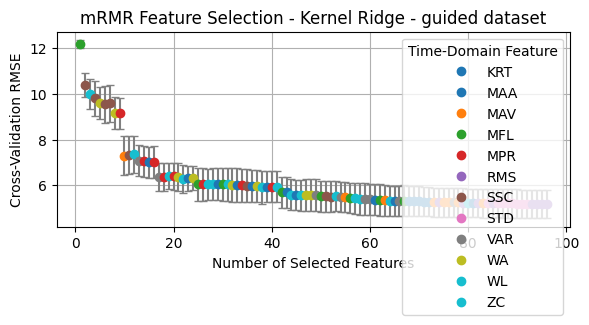

---------------------------------------------------------------------------
Evaluating mMRM feature selection of the model KNN on the guided dataset...


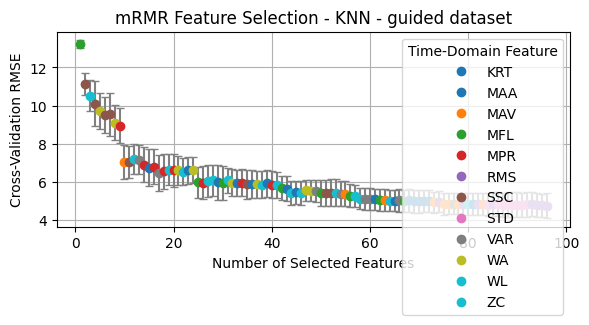

---------------------------------------------------------------------------
Evaluating mMRM feature selection of the model Random Forests on the guided dataset...


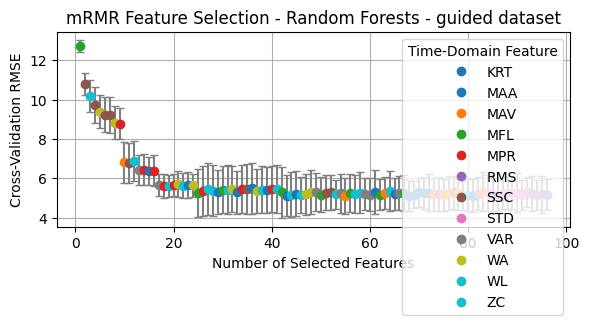

In [13]:
# Evaluation dataset guided

# Compute Mutual Info (includes feature extraction)
X_df, Y_all, mi_scores, X_sessions = compute_mi_vector(
    X_guided_windows_train_val_folds, 
    Y_guided_labels_train_val_folds, 
    TimeDomainTransformer(sigma_mpr=0.3)
    )

# Perform mRMR
selected = greedy_mrmr_selection(X_df, mi_scores)

models_feat_sel = {
    'Kernel Ridge': KernelRidge(
        alpha=0.01, 
        gamma=0.01, 
        kernel='laplacian'),
    'KNN': KNeighborsRegressor(n_neighbors=5),
    'Random Forests': RandomForestRegressor(
        n_estimators=50, 
        max_depth=10)
}
n_features = len(selected)
n_sessions = X_sessions.shape[0]
CV_results = {}

for model_name, model in models_feat_sel.items():
    print('---------------------------------------------------------------------------')
    print(f'Evaluating mMRM feature selection of the model {model_name} on the guided dataset...')
    CV_err_mrmr = np.zeros((n_features, n_sessions))
    
    for nb_features in range(1, n_features + 1):
        selected_indices = selected[:nb_features]
        pipeline = Pipeline([
            ('select', FeatureSelector(selected_indices)),
            ('scale', StandardScaler()),
            ('reg', model)
        ])
        try:
            cv_results = cross_validate_pipeline(
                pipeline,
                X_sessions,
                Y_guided_labels_train_val_folds,
                metric_fns={'RMSE': RMSE},
                n_folds=n_sessions,
                verbose=0
            )
        except Exception as e:
            print(f"Failed for model: {model_name} | #features: {nb_features}")
            print(e)
            break
        for fold_id in range(n_sessions):
            CV_err_mrmr[nb_features - 1, fold_id] = cv_results[fold_id]['val_RMSE']
    
    CV_results[model_name] = CV_err_mrmr
    
    # Plot results for the current model
    plot_mrmr_results(
        selected,
        CV_err_mrmr,
        td_feature_names=['MAV', 'RMS', 'VAR', 'STD', 'ZC', 'MPR',
                          'MAA', 'WL', 'SSC', 'WA', 'MFL', 'KRT'],
        title=f'mRMR Feature Selection - {model_name} - guided dataset'
    )

# If needed for inspection
# Report results (optional - you might not need this if you have the plots)
# for model_name, CV_err_mrmr in CV_results.items():
#     print(f"\nMRMR Feature Selection with {model_name}")
#     for i in range(n_features):
#         print(f"#Features: {i + 1}; CV error = {CV_err_mrmr[i, :].mean():.4f}; std dev = {CV_err_mrmr[i, :].std():.4f}")


Evaluating model: Kernel Ridge
---------------------------------------------------------------------------
Evaluating mMRM feature selection of the model Kernel Ridge on the freemoves dataset...


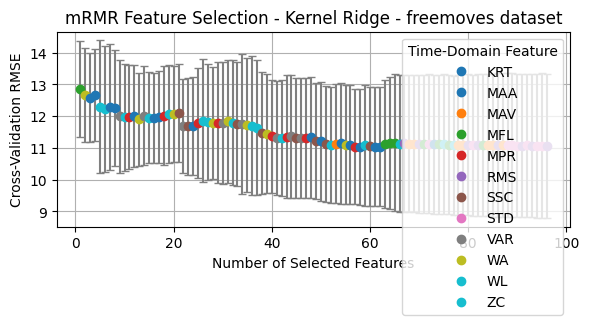


Evaluating model: KNN
---------------------------------------------------------------------------
Evaluating mMRM feature selection of the model KNN on the freemoves dataset...


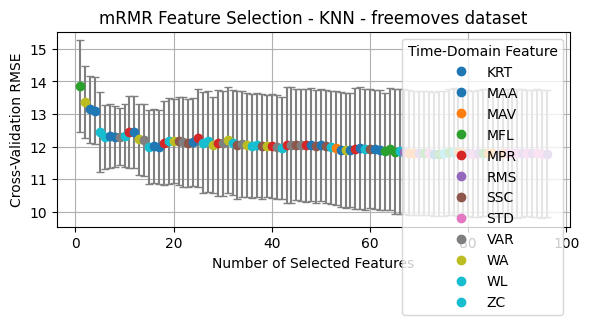


Evaluating model: Random Forests
---------------------------------------------------------------------------
Evaluating mMRM feature selection of the model Random Forests on the freemoves dataset...


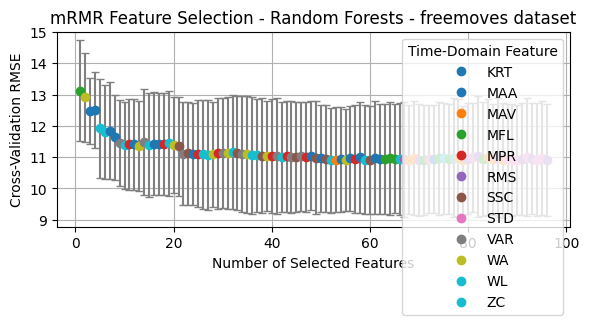

In [14]:
# Evaluation dataset freemoves

# Compute Mutual Info (includes feature extraction)
X_df, Y_all, mi_scores, X_sessions = compute_mi_vector(
    X_freemoves_windows_train_val_folds, 
    Y_freemoves_labels_train_val_folds, 
    TimeDomainTransformer(sigma_mpr=0.3)
    )

# Perform mRMR
selected = greedy_mrmr_selection(X_df, mi_scores)

# Models
models_feat_sel = {
    'Kernel Ridge': KernelRidge(
        alpha=0.01, 
        gamma=0.01, 
        kernel='laplacian'),
    'KNN': KNeighborsRegressor(n_neighbors=5),
    'Random Forests': RandomForestRegressor(
        n_estimators=50, 
        max_depth=10)
}
n_features = len(selected)
n_sessions = X_sessions.shape[0]
CV_results = {}

for model_name, model in models_feat_sel.items():
    print(f"\nEvaluating model: {model_name}")
    print('---------------------------------------------------------------------------')
    print(f'Evaluating mMRM feature selection of the model {model_name} on the freemoves dataset...')
    CV_err_mrmr = np.zeros((n_features, n_sessions))
    
    for nb_features in range(1, n_features + 1):
        selected_indices = selected[:nb_features]
        pipeline = Pipeline([
            ('select', FeatureSelector(selected_indices)),
            ('scale', StandardScaler()),
            ('reg', model)
        ])
        try:
            cv_results = cross_validate_pipeline(
                pipeline,
                X_sessions,
                Y_freemoves_labels_train_val_folds,
                metric_fns={'RMSE': RMSE},
                n_folds=n_sessions,
                verbose=0
            )
        except Exception as e:
            print(f"Failed for model: {model_name} | #features: {nb_features}")
            print(e)
            break
        for fold_id in range(n_sessions):
            CV_err_mrmr[nb_features - 1, fold_id] = cv_results[fold_id]['val_RMSE']
    
    CV_results[model_name] = CV_err_mrmr
    
    # Plot results for the current model
    plot_mrmr_results(
        selected,
        CV_err_mrmr,
        td_feature_names=['MAV', 'RMS', 'VAR', 'STD', 'ZC', 'MPR',
                          'MAA', 'WL', 'SSC', 'WA', 'MFL', 'KRT'],
        title=f'mRMR Feature Selection - {model_name} - freemoves dataset'
    )

# If needed for inspection
# Report results (optional - you might not need this if you have the plots)
# for model_name, CV_err_mrmr in CV_results.items():
#     print(f"\nMRMR Feature Selection with {model_name}")
#     for i in range(n_features):
#         print(f"#Features: {i + 1}; CV error = {CV_err_mrmr[i, :].mean():.4f}; std dev = {CV_err_mrmr[i, :].std():.4f}")

We evaluated RMSE across varying numbers of selected features using leave-one-session-out cross-validation. Here are the results near the optimal region (number reported for Kernel Ridge):

After visualizing the performance of different feature subset sizes using the plots titled "mRMR Feature Selection - [Model] - guided dataset", we examined the results to identify the optimal number of features. As an example, for the Kernel Ridge model, the RMSE across different numbers of selected features using leave-one-session-out cross-validation showed the following trend near the optimal region:

```text
#Features: 80; CV error = 5.2161; std dev = 0.6287  
#Features: 81; CV error = 5.2204; std dev = 0.6276  
#Features: 82; CV error = 5.2140; std dev = 0.6210  
#Features: 85; CV error = 5.2095; std dev = 0.6255  
#Features: 90; CV error = 5.1963; std dev = 0.6175  
#Features: 95; CV error = 5.1783; std dev = 0.6114  
#Features: 96; CV error = 5.1763; std dev = 0.6115
```

The results show that after 80 features, additional features provide the addition of more features yields only minimal improvements in the cross-validation RMSE,

To integrate feature selection directly into the learning pipeline, we implemented the `TopKMRMRSelector` class as a custom scikit-learn compatible transformer. This enables model training and evaluation without requiring separate preprocessing steps.
By setting k=80, we aim to utilize only the top 80 most relevant features as identified by the mRMR algorithm, improving interpretability and reducing the dimensionality the dimensionality of the feature space from the original 96 dimensions.

In [15]:
from config.transformers import TopKMRMRSelector

baseline_mrmr_kr = Pipeline(
    [
        ('feature_extraction', TimeDomainTransformer()),
        ('scaler', StandardScaler()),
        ('feature_select', TopKMRMRSelector(k=80)),
        ('regressor', KernelRidge(
            alpha = 0.01,
            gamma = 0.01,
            kernel='laplacian'))
    ]
)

baseline_mrmr_knn = Pipeline(
    [
        ('feature_extraction', TimeDomainTransformer()),
        ('scaler', StandardScaler()),
        ('feature_select', TopKMRMRSelector(k=80)),
        ('regressor', KNeighborsRegressor(
            n_neighbors = 5))
    ]
)

baseline_mrmr_rf = Pipeline(
    [
        ('feature_extraction', TimeDomainTransformer()),
        ('scaler', StandardScaler()),
        ('feature_select', TopKMRMRSelector(k=80)),
        ('regressor', RandomForestRegressor(
            n_estimators = 50,
            max_depth = 10))
    ]
)

We will now sistematically investigate the impact of the feature selection process, by re-evaluating the performance of our baseline models integrated with our custom feature-selection transformer.

#### 4-fold Leave-One-Session-Out cross-validation of baseline models + mRMR on *guided* dataset

In [16]:
print('---------------------------------------------------------------------------')
print('Cross-Validation of the pipeline "baseline_mrmr_kr" on the guided dataset:')
results_guided_baseline_mrmr_kr = cross_validate_pipeline(
    pipeline = baseline_mrmr_kr,
    X_folds = X_guided_windows_train_val_folds,
    Y_folds = Y_guided_labels_train_val_folds,
    metric_fns = {'RMSE': RMSE, 'NMSE': NMSE},
    n_folds = 4,
    # verbose 0: silent mode; verbose 1: only average across folds values printed; verbose 2: results of all folds printed
    verbose = 1
)

print('---------------------------------------------------------------------------')
print('Cross-Validation of the pipeline "baseline_mrmr_knn" on the guided dataset:')
results_guided_baseline_mrmr_knn = cross_validate_pipeline(
    pipeline = baseline_mrmr_knn,
    X_folds = X_guided_windows_train_val_folds,
    Y_folds = Y_guided_labels_train_val_folds,
    metric_fns = {'RMSE': RMSE, 'NMSE': NMSE},
    n_folds = 4,
    # verbose 0: silent mode; verbose 1: only average across folds values printed; verbose 2: results of all folds printed
    verbose = 1
)

print('---------------------------------------------------------------------------')
print('Cross-Validation of the pipeline "baseline_mrmr_rf" on the guided dataset:')
results_guided_baseline_mrmr_rf = cross_validate_pipeline(
    pipeline = baseline_mrmr_rf,
    X_folds = X_guided_windows_train_val_folds,
    Y_folds = Y_guided_labels_train_val_folds,
    metric_fns = {'RMSE': RMSE, 'NMSE': NMSE},
    n_folds = 4,
    # verbose 0: silent mode; verbose 1: only average across folds values printed; verbose 2: results of all folds printed
    verbose = 1
)

---------------------------------------------------------------------------
Cross-Validation of the pipeline "baseline_mrmr_kr" on the guided dataset:

Average Scores across folds:
RMSE: train=0.2133, val=5.2239
NMSE: train=0.0002, val=0.1380
---------------------------------------------------------------------------
Cross-Validation of the pipeline "baseline_mrmr_knn" on the guided dataset:

Average Scores across folds:
RMSE: train=2.1727, val=4.8403
NMSE: train=0.0235, val=0.1182
---------------------------------------------------------------------------
Cross-Validation of the pipeline "baseline_mrmr_rf" on the guided dataset:

Average Scores across folds:
RMSE: train=2.0149, val=5.0784
NMSE: train=0.0203, val=0.1319


#### 4-fold Leave-One-Session-Out cross-validation of baseline models + mRMR on *freemoves* dataset

In [17]:
print('---------------------------------------------------------------------------')
print('Cross-Validation of the pipeline "baseline_mrmr_kr" on the freemoves dataset:')
results_freemoves_baseline_mrmr_kr = cross_validate_pipeline(
    pipeline = baseline_mrmr_kr,
    X_folds = X_freemoves_windows_train_val_folds,
    Y_folds = Y_freemoves_labels_train_val_folds,
    metric_fns = {'RMSE': RMSE, 'NMSE': NMSE},
    n_folds = 4,
    # verbose 0: silent mode; verbose 1: only average across folds values printed; verbose 2: results of all folds printed
    verbose = 1
)

print('---------------------------------------------------------------------------')
print('Cross-Validation of the pipeline "baseline_mrmr_knn" on the freemoves dataset:')
results_freemoves_baseline_mrmr_knn = cross_validate_pipeline(
    pipeline = baseline_mrmr_knn,
    X_folds = X_freemoves_windows_train_val_folds,
    Y_folds = Y_freemoves_labels_train_val_folds,
    metric_fns = {'RMSE': RMSE, 'NMSE': NMSE},
    n_folds = 4,
    # verbose 0: silent mode; verbose 1: only average across folds values printed; verbose 2: results of all folds printed
    verbose = 1
)

print('---------------------------------------------------------------------------')
print('Cross-Validation of the pipeline "baseline_mrmr_rf" on the freemoves dataset:')
results_freemoves_baseline_mrmr_rf = cross_validate_pipeline(
    pipeline = baseline_mrmr_rf,
    X_folds = X_freemoves_windows_train_val_folds,
    Y_folds = Y_freemoves_labels_train_val_folds,
    metric_fns = {'RMSE': RMSE, 'NMSE': NMSE},
    n_folds = 4,
    # verbose 0: silent mode; verbose 1: only average across folds values printed; verbose 2: results of all folds printed
    verbose = 1
)

---------------------------------------------------------------------------
Cross-Validation of the pipeline "baseline_mrmr_kr" on the freemoves dataset:

Average Scores across folds:
RMSE: train=0.6668, val=11.0955
NMSE: train=0.0027, val=0.8256
---------------------------------------------------------------------------
Cross-Validation of the pipeline "baseline_mrmr_knn" on the freemoves dataset:

Average Scores across folds:
RMSE: train=6.5434, val=11.7802
NMSE: train=0.2605, val=0.9241
---------------------------------------------------------------------------
Cross-Validation of the pipeline "baseline_mrmr_rf" on the freemoves dataset:

Average Scores across folds:
RMSE: train=5.3874, val=10.9113
NMSE: train=0.1765, val=0.7939


## PCA

We will now turn our attention to the **Principal Component Analysis (PCA)** and how it can be used as a feature selection and dimensionality reduction technique to improve regression performance from EMG time-domain features.

We evaluate PCA-based dimensionality reduction by retaining different levels of explained variance, defined by the following thresholds:

```python
variance_thresholds = np.arange(0.85, 0.991, 0.01)
```

For each baseline regressor we:
- Build a scikit-learn pipeline with the regressor with a PCA step where the number of components is determined by the current variance_threshold
- Use cross_validate_pipeline() with a $4$-fold strategy to compute the average RMSE across the leave-one-session-out cross-validation folds for this pipeline configuration
- Fit PCA separately to compute the actual number of components retained at that threshold

We generate two plots (as subplots in one figure):

- **RMSE vs. Variance Retained**: Illustrates how the average cross-validation RMSE changes as we increase the amount of variance retained by PCA
- **Components vs. Variance Retained**: Visualizes the dimensionality reduction effect of PCA

---------------------------------------------------------------------------
Evaluating PCA feature selection of the model Kernel Ridge on the guided dataset...


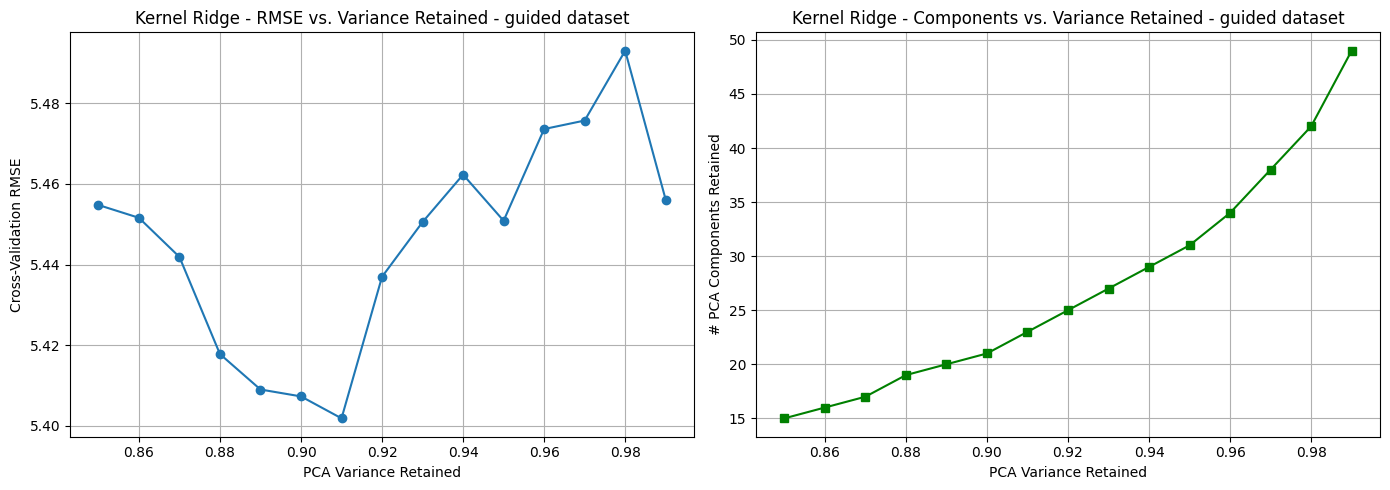

---------------------------------------------------------------------------
Evaluating PCA feature selection of the model KNN on the guided dataset...


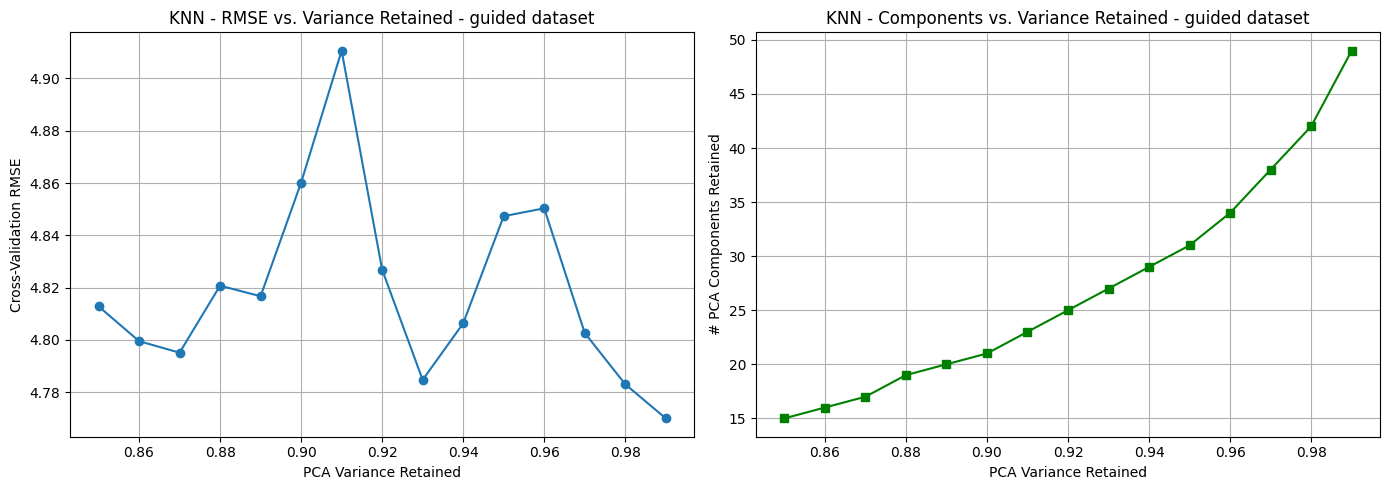

---------------------------------------------------------------------------
Evaluating PCA feature selection of the model Random Forests on the guided dataset...


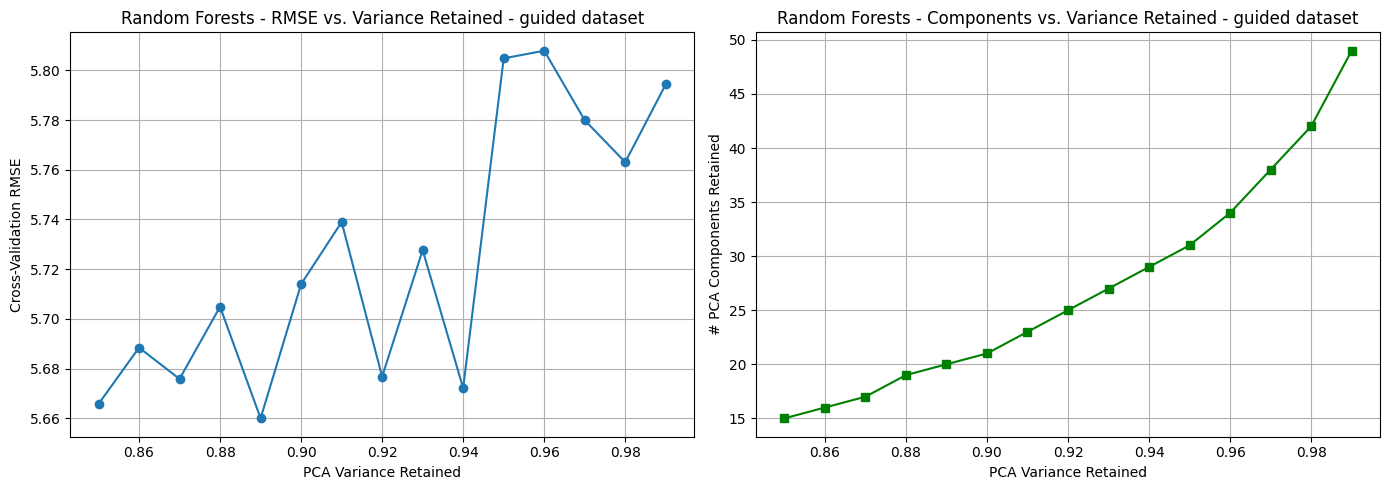

In [18]:
from sklearn.decomposition import PCA

# Evaluaton guided dataset
n_sessions, n_windows, n_channels, window_size = X_guided_windows_train_val_folds.shape

# Sweep PCA variance thresholds
variance_thresholds = np.arange(0.85, 0.991, 0.01)

for model_name, model in models_feat_sel.items():
    print('---------------------------------------------------------------------------')
    print(f'Evaluating PCA feature selection of the model {model_name} on the guided dataset...') 
    
    rmse_scores = []
    n_components_used = []

    for var in variance_thresholds:
        pipeline = Pipeline([
            ('td_feat', TimeDomainTransformer()),
            ('scale', StandardScaler()),
            ('pca', PCA(n_components=float(var), random_state=42)),
            ('reg', model)
        ])

        metric_fns = {'RMSE': RMSE}
        results = cross_validate_pipeline(
            pipeline,
            X_guided_windows_train_val_folds,
            Y_guided_labels_train_val_folds,
            metric_fns=metric_fns,
            verbose=0
        )

        # Fit once to extract # of components
        pipeline.fit(X_guided_windows_train_val_folds.reshape(-1, n_channels, window_size), 
                     Y_guided_labels_train_val_folds.reshape(-1, 51))
        n_comp = pipeline.named_steps['pca'].n_components_

        rmse_scores.append(results['avg_val_RMSE'])
        n_components_used.append(n_comp)

        # print(f"Variance: {var:.2f}, RMSE: {results['avg_val_RMSE']:.4f}, Components: {n_comp}")

    # Plots
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))

    # Plot 1: RMSE vs Variance Retained
    axs[0].plot(variance_thresholds, rmse_scores, marker='o')
    axs[0].set_xlabel("PCA Variance Retained")
    axs[0].set_ylabel("Cross-Validation RMSE")
    axs[0].set_title(f"{model_name} - RMSE vs. Variance Retained - guided dataset")
    axs[0].grid(True)

    # Plot 2: #Components vs Variance Retained
    axs[1].plot(variance_thresholds, n_components_used, marker='s', color='green')
    axs[1].set_xlabel("PCA Variance Retained")
    axs[1].set_ylabel("# PCA Components Retained")
    axs[1].set_title(f"{model_name} - Components vs. Variance Retained - guided dataset")
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()

---------------------------------------------------------------------------
Evaluating PCA feature selection of the model Kernel Ridge on the freemoves dataset...


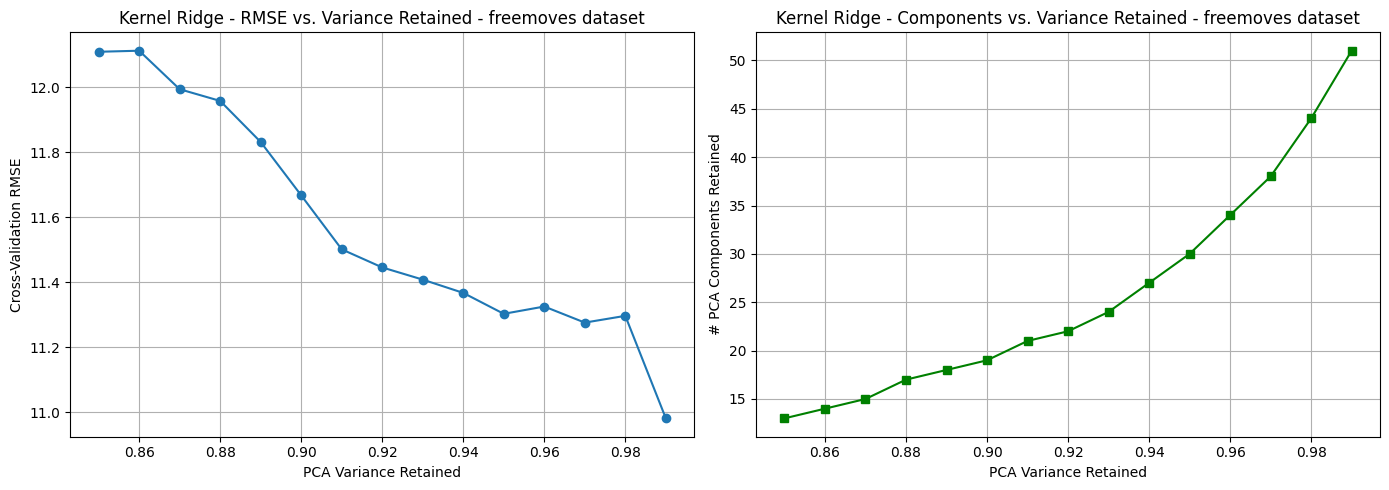

---------------------------------------------------------------------------
Evaluating PCA feature selection of the model KNN on the freemoves dataset...


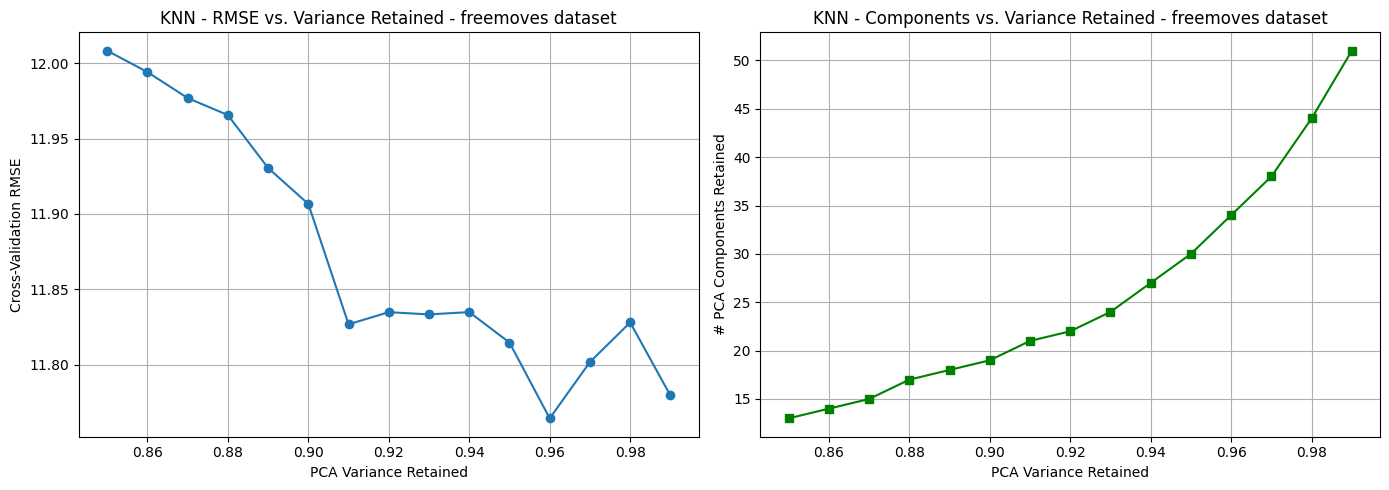

---------------------------------------------------------------------------
Evaluating PCA feature selection of the model Random Forests on the freemoves dataset...


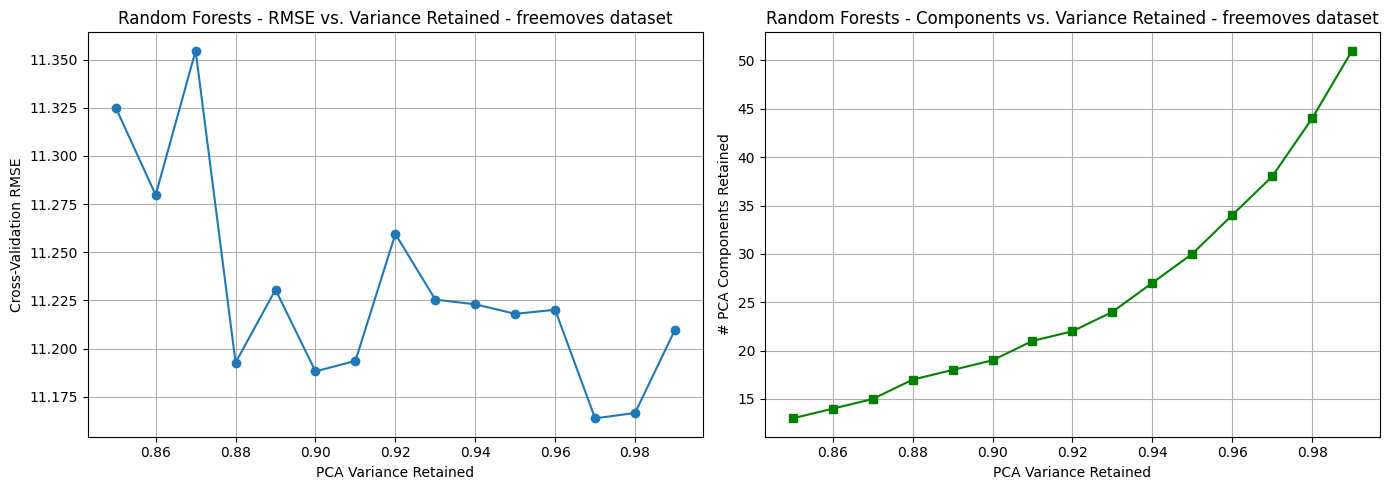

In [19]:
# Evaluaton freemoves dataset
n_sessions, n_windows, n_channels, window_size = X_freemoves_windows_train_val_folds.shape

# Sweep PCA variance thresholds
variance_thresholds = np.arange(0.85, 0.991, 0.01)

for model_name, model in models_feat_sel.items():
    print('---------------------------------------------------------------------------')
    print(f'Evaluating PCA feature selection of the model {model_name} on the freemoves dataset...') 
    
    rmse_scores = []
    n_components_used = []

    for var in variance_thresholds:
        pipeline = Pipeline([
            ('td_feat', TimeDomainTransformer()),
            ('scale', StandardScaler()),
            ('pca', PCA(n_components=float(var), random_state=42)),
            ('reg', model)
        ])

        metric_fns = {'RMSE': RMSE}
        results = cross_validate_pipeline(
            pipeline,
            X_freemoves_windows_train_val_folds,
            Y_freemoves_labels_train_val_folds,
            metric_fns=metric_fns,
            verbose=0
        )

        # Fit once to extract # of components
        pipeline.fit(X_freemoves_windows_train_val_folds.reshape(-1, n_channels, window_size), 
                     Y_freemoves_labels_train_val_folds.reshape(-1, 51))
        n_comp = pipeline.named_steps['pca'].n_components_

        rmse_scores.append(results['avg_val_RMSE'])
        n_components_used.append(n_comp)

        # print(f"Variance: {var:.2f}, RMSE: {results['avg_val_RMSE']:.4f}, Components: {n_comp}")

    # Plots
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))

    # Plot 1: RMSE vs Variance Retained
    axs[0].plot(variance_thresholds, rmse_scores, marker='o')
    axs[0].set_xlabel("PCA Variance Retained")
    axs[0].set_ylabel("Cross-Validation RMSE")
    axs[0].set_title(f"{model_name} - RMSE vs. Variance Retained - freemoves dataset")
    axs[0].grid(True)

    # Plot 2: #Components vs Variance Retained
    axs[1].plot(variance_thresholds, n_components_used, marker='s', color='green')
    axs[1].set_xlabel("PCA Variance Retained")
    axs[1].set_ylabel("# PCA Components Retained")
    axs[1].set_title(f"{model_name} - Components vs. Variance Retained - freemoves dataset")
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()

We observed that RMSE improves only marginally with initial increases in explained variance. However, beyond 0.90, further increases yield almost no RMSE improvements despite adding more components. Choosing much higher variance thresholds adds complexity without substantial accuracy gains, increasing overfitting risk and computation. 

Therefore, we selected an explained variance threshold near this 0.9 This balances:

* **Performance:** Accuracy close to the maximum.
* **Dimensionality Reduction:** Fewer features for a simpler model.
* **Generalization:** Reduced risk of overfitting.
* **Efficiency:** Lower computational cost.

In [20]:
var = 0.9

baseline_pca_kr = Pipeline(
    [
        ('feature_extraction', TimeDomainTransformer()),
        ('scaler', StandardScaler()),
        ('feature_select', PCA(n_components=float(var), random_state=42)),
        ('regressor', KernelRidge(
            alpha = 0.01,
            gamma = 0.01,
            kernel='laplacian'))
    ]
)

baseline_pca_knn = Pipeline(
    [
        ('feature_extraction', TimeDomainTransformer()),
        ('scaler', StandardScaler()),
        ('feature_select', PCA(n_components=float(var), random_state=42)),
        ('regressor', KNeighborsRegressor(
            n_neighbors = 5))
    ]
)

baseline_pca_rf = Pipeline(
    [
        ('feature_extraction', TimeDomainTransformer()),
        ('scaler', StandardScaler()),
        ('feature_select', PCA(n_components=float(var), random_state=42)),
        ('regressor', RandomForestRegressor(
            n_estimators = 50,
            max_depth = 10))
    ]
)

We now re-evaluate our baseline models with integrated PCA-based feature selection.

#### 4-fold Leave-One-Session-Out cross-validation of baseline models + mMRM on *guided* dataset

In [21]:
print('---------------------------------------------------------------------------')
print('Cross-Validation of the pipeline "baseline_pca_kr" on the guided dataset:')
results_guided_baseline_pca_kr = cross_validate_pipeline(
    pipeline = baseline_pca_kr,
    X_folds = X_guided_windows_train_val_folds,
    Y_folds = Y_guided_labels_train_val_folds,
    metric_fns = {'RMSE': RMSE, 'NMSE': NMSE},
    n_folds = 4,
    # verbose 0: silent mode; verbose 1: only average across folds values printed; verbose 2: results of all folds printed
    verbose = 1
)

print('---------------------------------------------------------------------------')
print('Cross-Validation of the pipeline "baseline_pca_knn" on the guided dataset:')
results_guided_baseline_pca_knn = cross_validate_pipeline(
    pipeline = baseline_pca_knn,
    X_folds = X_guided_windows_train_val_folds,
    Y_folds = Y_guided_labels_train_val_folds,
    metric_fns = {'RMSE': RMSE, 'NMSE': NMSE},
    n_folds = 4,
    # verbose 0: silent mode; verbose 1: only average across folds values printed; verbose 2: results of all folds printed
    verbose = 1
)

print('---------------------------------------------------------------------------')
print('Cross-Validation of the pipeline "baseline_pca_rf" on the guided dataset:')
results_guided_baseline_pca_rf = cross_validate_pipeline(
    pipeline = baseline_pca_rf,
    X_folds = X_guided_windows_train_val_folds,
    Y_folds = Y_guided_labels_train_val_folds,
    metric_fns = {'RMSE': RMSE, 'NMSE': NMSE},
    n_folds = 4,
    # verbose 0: silent mode; verbose 1: only average across folds values printed; verbose 2: results of all folds printed
    verbose = 1
)

---------------------------------------------------------------------------
Cross-Validation of the pipeline "baseline_pca_kr" on the guided dataset:

Average Scores across folds:
RMSE: train=0.7717, val=5.4072
NMSE: train=0.0030, val=0.1471
---------------------------------------------------------------------------
Cross-Validation of the pipeline "baseline_pca_knn" on the guided dataset:

Average Scores across folds:
RMSE: train=2.1391, val=4.8602
NMSE: train=0.0228, val=0.1190
---------------------------------------------------------------------------
Cross-Validation of the pipeline "baseline_pca_rf" on the guided dataset:

Average Scores across folds:
RMSE: train=2.8406, val=5.7435
NMSE: train=0.0402, val=0.1656


#### 4-fold Leave-One-Session-Out cross-validation of baseline models + PCA on *freemoves* dataset

In [22]:
print('---------------------------------------------------------------------------')
print('Cross-Validation of the pipeline "baseline_pca_kr" on the freemoves dataset:')
results_freemoves_baseline_pca_kr = cross_validate_pipeline(
    pipeline = baseline_pca_kr,
    X_folds = X_freemoves_windows_train_val_folds,
    Y_folds = Y_freemoves_labels_train_val_folds,
    metric_fns = {'RMSE': RMSE, 'NMSE': NMSE},
    n_folds = 4,
    # verbose 0: silent mode; verbose 1: only average across folds values printed; verbose 2: results of all folds printed
    verbose = 1
)

print('---------------------------------------------------------------------------')
print('Cross-Validation of the pipeline "baseline_pca_knn" on the freemoves dataset:')
results_freemoves_baseline_pca_knn = cross_validate_pipeline(
    pipeline = baseline_pca_knn,
    X_folds = X_freemoves_windows_train_val_folds,
    Y_folds = Y_freemoves_labels_train_val_folds,
    metric_fns = {'RMSE': RMSE, 'NMSE': NMSE},
    n_folds = 4,
    # verbose 0: silent mode; verbose 1: only average across folds values printed; verbose 2: results of all folds printed
    verbose = 1
)

print('---------------------------------------------------------------------------')
print('Cross-Validation of the pipeline "baseline_pca_rf" on the freemoves dataset:')
results_freemoves_baseline_pca_rf = cross_validate_pipeline(
    pipeline = baseline_pca_rf,
    X_folds = X_freemoves_windows_train_val_folds,
    Y_folds = Y_freemoves_labels_train_val_folds,
    metric_fns = {'RMSE': RMSE, 'NMSE': NMSE},
    n_folds = 4,
    # verbose 0: silent mode; verbose 1: only average across folds values printed; verbose 2: results of all folds printed
    verbose = 1
)

---------------------------------------------------------------------------
Cross-Validation of the pipeline "baseline_pca_kr" on the freemoves dataset:

Average Scores across folds:
RMSE: train=2.4232, val=11.6675
NMSE: train=0.0357, val=0.9075
---------------------------------------------------------------------------
Cross-Validation of the pipeline "baseline_pca_knn" on the freemoves dataset:

Average Scores across folds:
RMSE: train=6.8741, val=11.9066
NMSE: train=0.2874, val=0.9443
---------------------------------------------------------------------------
Cross-Validation of the pipeline "baseline_pca_rf" on the freemoves dataset:

Average Scores across folds:
RMSE: train=5.9087, val=11.1906
NMSE: train=0.2120, val=0.8321


# Riemannian Geometry-based pipelines 

We will now enrich our arsenal of estimators, by developing three new pipelines based on the **Riemannian geometry of covariance matrices**.

The baseline pipelines developed above formulate predictions based on simple *time-domain features* extracted from EMG time windows. By contrast, we will now define estimators that formulate predictions based on *covariance matrices* extracted from EMG time windows.

As described above, a EMG time window comes in the form of a numpy array `X` of shape `(8, 500)`. By employing the transformer `pyriemann.estimation.Covariances()` from the freely available library `pyriemann`, we can extract a covariance matrix `X_covariance` of shape `(8, 8)`.

More precisely, we can think of `X` as a sample $\mathbf{x} = (x_1,...,x_8)$ from a random vector $\mathbf{X} = (X_1,...,X_8)$. We can then estimate its covariance $\text{Cov}(\mathbf{X}) = \text{Cov}(X_i, X_j)$ in terms of the *sample covariance matrix* of $\mathbf{x}$. The result is a $8\times8$ *symmetric and positive-semidefinite* matrix.

8x8 symmetric matrices form a vector space of dimension 36, parametrized by the entries of the upper-triangular part of the matrix. However, the Euclidean geometry of $\mathbb R^{36}$ is not well-suited to describe distances between covariance matrices. Indeed, the subset of *positive-semidefinite* matrices can be equipped with more appropriate natural geometries, encoded in the form of *Riemannian metrics*. The set of positive-semidefinite 8x8 symmetric matrices, equipped with a Riemannian metric, becomes a 36-dimensional *curved* manifold.

The library `pyriemann` exploits these metrics to implement classification and regression models. However, using the intrinsic Riemannian geometry of this manifold can be computationally quite expensive. For this reason, it is convenient to take a first-order approximation of the manifold, by *projecting orthogonally* the covariance matrices to a tangent space. The tangent space at a point is a 36-dimensional *Euclidean* vector space, representing a *linear* approximation of the curved manifold near the given point. Projections to the tangent space thus provide features in the form of vectors in Euclidean space, on which standard regressors and estimators can be used.

This projection procedure is implemented in `pyriemann` in the form of a sklearn-compatible transformer. Specifically, an instance of the class `pyriemann.tangentspace.TangentSpace` has:

- a `.fit(X, y)` method, where `X` is a numpy array of covariance matrices (shape `(n_matrices, n_channels, n_channels)`), with `y` not used but included for compatibility with sklearn; this method computes and stores internally the Riemannian average of the covariance matrices;

- a `.transform(X)` method, which (if called after `.fit()`) takes in input a numpy array of covariance matrices (shape `(n_matrices, n_channels, n_channels)`) and returns the orthogonal projections of these matrices to the tangent space at the Riemannian average (shape `(n_matrices, n_channels * n_channels)`).

Our Riemannian-based pipelines will follow a common pipeline structure:

1. **Covariance Estimation**  
   `pyriemann.estimation.Covariances()`  
   - Computes the covariance matrix from EMG channels per time window.

2. **Tangent Space Projection**  
   `pyriemann.tangentspace.TangentSpace(metric='riemann', tsupdate=True)`  
   - Projects the SPD matrices onto the tangent space at the Riemannian mean.
   - `tsupdate=True` allows updating the tangent space mean at transform time.

3. **Feature Scaling**  
   `StandardScaler()`
   - Standard normalization to mean 0 and unit variance.

4. **Regression Model**  
   - Varies across pipelines below.

As regression model we use again:
   
   - **Kernel Ridge Regression**

   - **K-Nearest Neighbors Regression**

   - **Random Forest Regression**

The reasons for this particular choice are the same explained in the section describing the baseline pipelines: after some experiments, these models perform reasonably well compare to the others, and they are sufficiently different to ensure good improvement when considered together in an ensemble model.

In [23]:
import pyriemann
import pyriemann.regression

In [24]:
# Riemannian-based pipelines
riem_kr = Pipeline(
    [
        ('feature_extraction', pyriemann.estimation.Covariances()),
        ('transformation', pyriemann.tangentspace.TangentSpace(
            metric = 'riemann',
            tsupdate = True)),
        ('scaler', StandardScaler()),
        ('regressor', KernelRidge(
            alpha = 0.01,
            gamma = 0.01,
            kernel='laplacian'))
    ]
)

riem_knn = Pipeline(
    [
        ('feature_extraction', pyriemann.estimation.Covariances()),
        ('transformation', pyriemann.tangentspace.TangentSpace(
            metric = 'riemann',
            tsupdate = True)),
        ('scaler', StandardScaler()),
        ('regressor', KNeighborsRegressor(
            n_neighbors = 5))
    ]
)

riem_rf = Pipeline(
    [
        ('feature_extraction', pyriemann.estimation.Covariances()),
        ('transformation', pyriemann.tangentspace.TangentSpace(
            metric = 'riemann',
            tsupdate = True)),
        ('scaler', StandardScaler()),
        ('regressor', RandomForestRegressor(
            n_estimators = 50,
            max_depth = 10))
    ]
)

As for the baseline models, we cross-validate these models on the train-val part of the dataset, by means of **Leave-One-Session-Out 4-fold cross-validation**.

#### 4-fold Leave-One-Session-Out cross-validation of Riemannian models on *guided* dataset

In [25]:
print('---------------------------------------------------------------------------')
print('Cross-Validation of the pipeline "riem_kr" on the guided dataset:')
results_guided_riem_kr = cross_validate_pipeline(
    pipeline = baseline_kr,
    X_folds = X_guided_windows_train_val_folds,
    Y_folds = Y_guided_labels_train_val_folds,
    metric_fns = {'RMSE': RMSE, 'NMSE': NMSE},
    n_folds = 4,
    # verbose 0: silent mode; verbose 1: only average across folds values printed; verbose 2: results of all folds printed
    verbose = 1
)

print('---------------------------------------------------------------------------')
print('Cross-Validation of the pipeline "riem_knn" on the guided dataset:')
results_guided_riem_knn = cross_validate_pipeline(
    pipeline = baseline_knn,
    X_folds = X_guided_windows_train_val_folds,
    Y_folds = Y_guided_labels_train_val_folds,
    metric_fns = {'RMSE': RMSE, 'NMSE': NMSE},
    n_folds = 4,
    # verbose 0: silent mode; verbose 1: only average across folds values printed; verbose 2: results of all folds printed
    verbose = 1
)

print('---------------------------------------------------------------------------')
print('Cross-Validation of the pipeline "riem_rf" on the guided dataset:')
results_guided_riem_rf = cross_validate_pipeline(
    pipeline = baseline_rf,
    X_folds = X_guided_windows_train_val_folds,
    Y_folds = Y_guided_labels_train_val_folds,
    metric_fns = {'RMSE': RMSE, 'NMSE': NMSE},
    n_folds = 4,
    # verbose 0: silent mode; verbose 1: only average across folds values printed; verbose 2: results of all folds printed
    verbose = 1
)

---------------------------------------------------------------------------
Cross-Validation of the pipeline "riem_kr" on the guided dataset:

Average Scores across folds:
RMSE: train=0.1764, val=5.1763
NMSE: train=0.0002, val=0.1354
---------------------------------------------------------------------------
Cross-Validation of the pipeline "riem_knn" on the guided dataset:

Average Scores across folds:
RMSE: train=2.0971, val=4.7569
NMSE: train=0.0219, val=0.1144
---------------------------------------------------------------------------
Cross-Validation of the pipeline "riem_rf" on the guided dataset:

Average Scores across folds:
RMSE: train=2.0057, val=5.1411
NMSE: train=0.0201, val=0.1363


#### 4-fold Leave-One-Session-Out cross-validation of Riemannian models on *freemoves* dataset

In [26]:
print('---------------------------------------------------------------------------')
print('Cross-Validation of the pipeline "riem_kr" on the freemoves dataset:')
results_freemoves_riem_kr = cross_validate_pipeline(
    pipeline = baseline_kr,
    X_folds = X_freemoves_windows_train_val_folds,
    Y_folds = Y_freemoves_labels_train_val_folds,
    metric_fns = {'RMSE': RMSE, 'NMSE': NMSE},
    n_folds = 4,
    # verbose 0: silent mode; verbose 1: only average across folds values printed; verbose 2: results of all folds printed
    verbose = 1
)

print('---------------------------------------------------------------------------')
print('Cross-Validation of the pipeline "riem_knn" on the freemoves dataset:')
results_freemoves_riem_knn = cross_validate_pipeline(
    pipeline = baseline_knn,
    X_folds = X_freemoves_windows_train_val_folds,
    Y_folds = Y_freemoves_labels_train_val_folds,
    metric_fns = {'RMSE': RMSE, 'NMSE': NMSE},
    n_folds = 4,
    # verbose 0: silent mode; verbose 1: only average across folds values printed; verbose 2: results of all folds printed
    verbose = 1
)

print('---------------------------------------------------------------------------')
print('Cross-Validation of the pipeline "riem_rf" on the freemoves dataset:')
results_freemoves_riem_rf = cross_validate_pipeline(
    pipeline = baseline_rf,
    X_folds = X_freemoves_windows_train_val_folds,
    Y_folds = Y_freemoves_labels_train_val_folds,
    metric_fns = {'RMSE': RMSE, 'NMSE': NMSE},
    n_folds = 4,
    # verbose 0: silent mode; verbose 1: only average across folds values printed; verbose 2: results of all folds printed
    verbose = 1
)

---------------------------------------------------------------------------
Cross-Validation of the pipeline "riem_kr" on the freemoves dataset:

Average Scores across folds:
RMSE: train=0.5570, val=11.0657
NMSE: train=0.0019, val=0.8219
---------------------------------------------------------------------------
Cross-Validation of the pipeline "riem_knn" on the freemoves dataset:

Average Scores across folds:
RMSE: train=6.5231, val=11.7761
NMSE: train=0.2589, val=0.9244
---------------------------------------------------------------------------
Cross-Validation of the pipeline "riem_rf" on the freemoves dataset:

Average Scores across folds:
RMSE: train=5.3871, val=10.9584
NMSE: train=0.1766, val=0.8018


# Domain-Adversarial Neural Network (DANN)

In EMG-based regression, **inter-session variability** presents a key challenge to generalisation. Signals can differ substantially across recording sessions due to factors such as:

- Electrode placement drift
- Muscle fatigue or tension variation
- Electrical noise or impedance shifts
- Skin conductivity changes over time

Even when gestures are performed identically, the signal shapes and amplitudes can vary — this is clearly visible when comparing sessions directly.

### Empirical check of session variability

To substantiate the use of domain-adversarial learning, we first note that our **baseline models exhibit poor cross-session generalisation** showing **one fold significantly underperforming the others**. This suggests that the model overfits to session-specific features.
Rather than relying solely on loss metrics, we tried visually highlight this phenomenon. We propose computing a **per-session signal profile summary**, using variance or magnitude-based time features (e.g., mean absolute value, waveform length, etc.) aggregated over all windows and channels. This provides a condensed summary of the **typical signal signature** for each freemoves session.

<br>

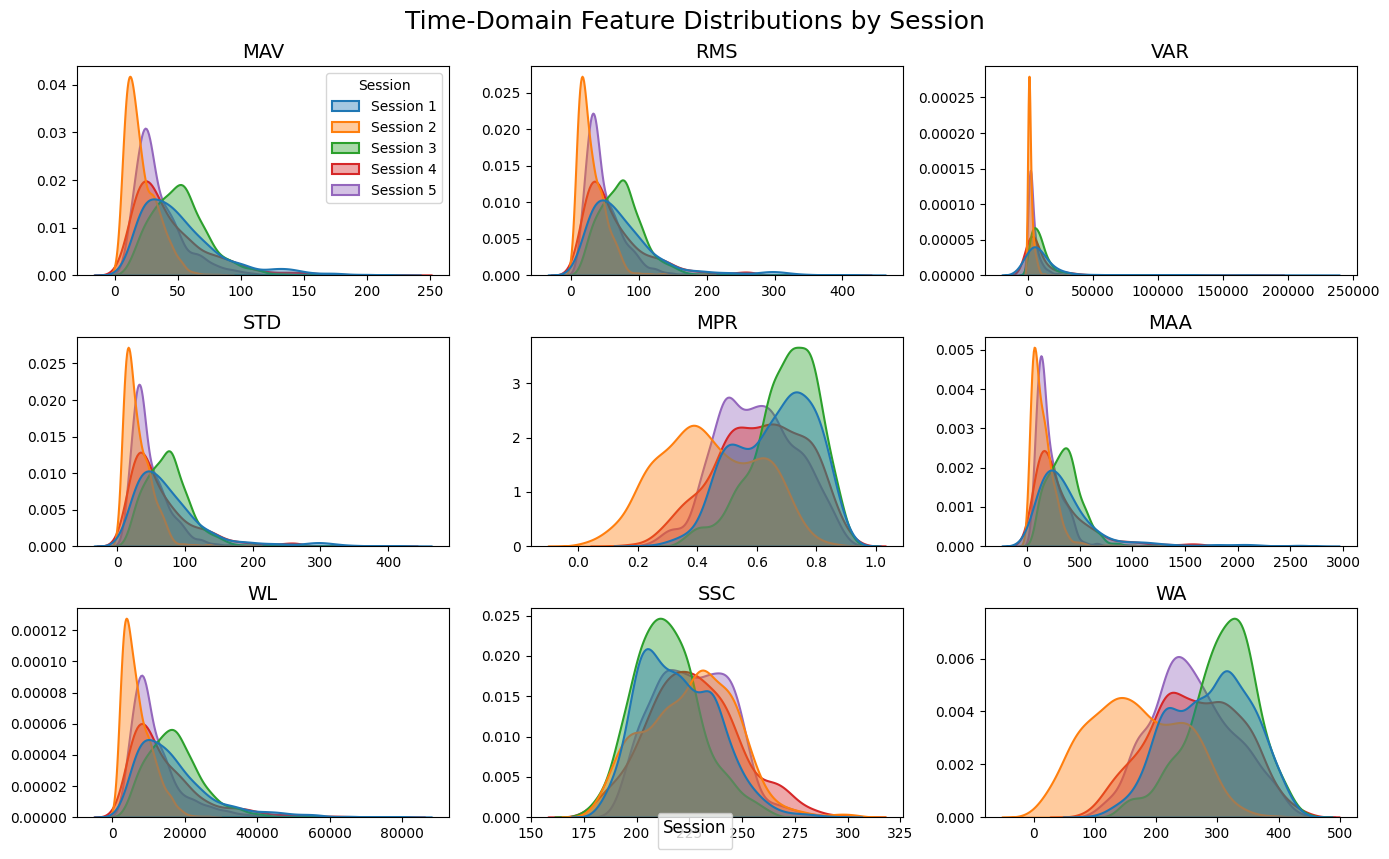


<br>

Such a summary figure helps confirm that:
- Each session indeed has a **distinct signal signature**
- Domain shifts are large enough across the sessions to justify using a **domain-adversarial approach** especially with regards to our session sample size (=5) 

In this context, DANN becomes essential: it penalises representations that retain session identity and enforces learning of **shared signal structure**, not session-specific noise. Rather than rely on classical regularisation alone, we use **domain-adversarial training** to penalise representations that encode session-specific information.

The core idea is: 
- If a feature extractor allows a domain classifier to easily identify which session a signal comes from, then it is learning features that are not session-invariant.  
- DANN flips the gradients from the domain classifier to *discourage* such behaviour.

By integrating a **domain classifier and gradient reversal layer**, we force the network to **learn features that generalise across sessions**, leading to more robust predictions even on unseen recordings.

According to the litterature, [(Zia ur Rehman et al., 2020)](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=9027853), [(Dai et al.,2019)](https://www.mdpi.com/1424-8220/19/3/551), [(Karnam et al., 2022)](https://www.sciencedirect.com/science/article/abs/pii/S0208521622000080?via%3Dihub), convolutional Neural Networks (CNNs) are well-suited to modelling **temporal and spatial patterns** in time-series data like EMG. The reasons are:

- They can detect **local patterns** (e.g. bursts or waves) that correspond to muscle activation
- They **share weights** across time, ensuring translation-invariance
- They efficiently extract features over long time windows without exploding parameter counts

This makes CNNs particularly effective for EMG feature extraction, especially when combined with DANN to learn session-agnostic representations.

### Architecture

The approach taken involves 3 implemented models, a standard Convolutional Neural Network (CNN) - `ConvNN`- and two variants of a Domain Adversarial Neural Network (DANN) - `DANNModel`, `TemporalDANNModel`.
In order to clearly highlight the model structures, each component is tagged with associated model. 

> #### 1. Convolutional Feature Extractor — `ConvNN`, `DANNModel`, `TemporalDANNModel`
> 
> - **Purpose:** Encodes the multi-channel sEMG signal into a low-dimensional representation that retains information relevant for predicting joint angles.
> - **Input:** A tensor of shape `(batch_size, channels, time)`, where `channels = 8` for raw signals or `channels = 24`, `channels = 16` when stacking raw with first, and/or second derivatives (Δ, Δ²).
> - **Architecture:** A sequence of 1D convolutional layers along the temporal axis, interleaved with Batch Normalization, ReLU activations, dropout, and (optionally) pooling. The final temporal dimension is aggregated using global average pooling.
> - **Output:** A fixed-size latent feature vector of shape `(batch_size, 128)`, used as input to the regressor and (in DANN models) the domain classifier.


<br>

> #### 2. Regressor Head — `ConvNN`, `DANNModel`, `TemporalDANNModel`
> 
> - **Purpose:** Translates the latent feature representation into a vector of joint angle estimates.
> - **Input:** A 128-dimensional vector output from the convolutional feature extractor.
> - **Architecture:** A fully connected feedforward network:
>   - `Linear(128 → 256)` → BatchNorm → ReLU → Dropout
>   - `Linear(256 → 64)` → BatchNorm → ReLU → Dropout
>   - `Linear(64 → 51)`
> - **Output:** A real-valued vector of shape `(batch_size, 51)`, corresponding to the predicted rotation angles of 17 finger joints (3 degrees of freedom each).
> - **Loss Function:** Mean Squared Error (MSE) between predicted and ground truth joint angles.

<br>

> #### 3. Domain Classifier + Gradient Reversal Layer (GRL) - `DANNModel`, `TemporalDANNModel`
> 
> - **Purpose:** Attempts to classify which session the input signal came from.
> - **Architecture:** A lightweight classifier, shallow NN, producing a probability distribution over the session domain labels.
> - **Gradient Reversal Layer (GRL):** During backpropagation, the GRL inverts the gradient signal coming from the domain classifier. This encourages the feature extractor to **remove session-specific information**.
> 
> By penalising features that allow easy domain classification, the feature extractor is encouraged to learn **session-invariant representations**, improving generalisation. This block is thus built over a convolutional block to form the DANN models (`DANNModel`, `TemporalDANNModel`)


### Training Strategy


While the `ConvNN` model follows a regular Adam gradient descent approach the DANN models (`DANNModel`, `TemporalDANNModel`) includes additional components in its loss function.

Specifically, the model minimises the following total loss:

$$
\mathcal{L}_{\text{total}} = \mathcal{L}_{\text{reg}} + \lambda \cdot \mathcal{L}_{\text{domain}} - \gamma \cdot \mathcal{H}(\text{domain\_pred})
$$

Where:
- $\mathcal{L}_{\text{reg}}$: Mean Squared Error (MSE) between predicted and true joint angles  
- $\mathcal{L}_{\text{domain}}$: Cross-entropy loss on predicted session (domain)  
- $\mathcal{H}$: Shannon entropy of the domain prediction distribution (optional regulariser)  
- $\lambda$: Adversarial weighting factor (annealed from 0 to 1)  
- $\gamma$: Entropy regularisation coefficient (typically small, e.g. 0.05–0.1)

At each iteration during training:

1. The EMG input $x$ is passed through the **feature extractor**, producing latent features.
2. These features are passed to:
   - The **regressor**, which outputs joint angle predictions $\hat{y}$
   - The **domain classifier**, via a **Gradient Reversal Layer**, which outputs session prediction logits
3. The three loss components are computed and combined into the total loss.
4. A single backward pass updates all parameters jointly, with the GRL flipping gradients flowing into the feature extractor from the domain classifier.


### Implementation


The implementation of the DANN model is done creating compatible torch modules, implemented in config.models:

- `class DANNTrainer`: Manages the full training loop for DANN, including:

   - Gradient reversal and joint optimisation of regression + domain losses
   - Cross-session early stopping
   - Composite loss: (see above)
   
- `class DANNModel(nn.Module)`: Defines the core Domain-Adversarial Neural Network architecture. It encapsulates the three key submodules:

   1. `ConvFeatureExtractor`:  
      CNN-based block transforming EMG windows of shape `(batch_size, 8, 500)` into compact 128-dim features.
   2. `RegressorHead`:  
      Fully connected layers that map latent features to the 51 joint-angle outputs.
   3. `DomainDiscriminator`:  
      Lightweight classifier (MLP) to predict session identity. Connected via a **Gradient Reversal Layer (GRL)** to encourage domain-invariant feature learning.

- `class TemporalDANNModel(nn.Module)`: In line with the `DANNModel`, it encapsulates the three key submodules with the addition of a flexible convolution block (arg: mode) with variable input channel sizes:

   1. `TemporalConvFeatureExtractor` or `TemporalConvFeatureExtractor2`:  
      CNN-based block transforming EMG windows of shape `(batch_size, 8, 500)` into compact 128-dim features w/ `TemporalConvFeatureExtractor2` able to handle variable input channels sizes for augmented Signal processing.
   2. `RegressorHead`:  
      Fully connected layers that map latent features to the 51 joint-angle outputs.
   3. `DomainDiscriminator`:  
      Lightweight classifier (MLP) to predict session identity. Connected via a **Gradient Reversal Layer (GRL)** to encourage domain-invariant feature learning.

- `class ConvNN(nn.Module)`: Defines our base benchmarking Convolutional Neural Network architecture. It builds over the two hardcoded attributes:

   1. `features`:  
      CNN-based block transforming EMG windows of shape `(batch_size, 8, 500)` into compact 128-dim features, similar to `ConvFeatureExtractor` in the DANN models.
   2. `fc`:
      A shallow set of fully connected layers that map latent features to the 51 joint-angle outputs.

To be consistent with our cross-validation strategy, we also created a `cross_validate_dann` function to automates the session-wise **leave-one-session-out** cross-validation for DANN training. The function works in following way:

1. Splits the 5 sessions into 4 training and 1 validation.
2. Constructs appropriate session IDs for domain classification.
3. Trains a new `DANNModel` per fold with fresh `DANNTrainer`.
4. Aggregates RMSE scores across folds.

Results submitted and performance obtained is also the result of manual hyperparameter tuning (learning rate, lambda, gamma, ...) using the same approach as defined in the subsection on baseline regressors.


In [6]:
from config.dann import DataLoader, DANNModel, DANNTrainer, DANNWindowTensor, DANNRegressor, TemporalDANNModel, cross_validate_dann, DeltaFeatureTransformer
from config.validation import cross_validate_NN, RMSE, NMSE
from config.loss_functions import RMSELoss
from config.models import ConvNN
from config.regressors import NNRegressor


#### Benchmark: 4-fold Leave-One-Session-Out cross-validation of CNN model on *guided* dataset - 

FOLD 1/4
Epoch 001 | Train Loss: 21.4545 | Val Loss: 20.8678 | 
Epoch 002 | Train Loss: 19.7038 | Val Loss: 18.4125 | 
Epoch 003 | Train Loss: 17.7890 | Val Loss: 17.0992 | 
Epoch 004 | Train Loss: 16.1040 | Val Loss: 15.6320 | 
Epoch 005 | Train Loss: 14.3600 | Val Loss: 13.6015 | 
Epoch 006 | Train Loss: 12.8034 | Val Loss: 12.0997 | 
Epoch 007 | Train Loss: 11.6664 | Val Loss: 10.7814 | 
Epoch 008 | Train Loss: 10.7635 | Val Loss: 10.2685 | 
Epoch 009 | Train Loss: 10.1357 | Val Loss: 9.8887 | 
Epoch 010 | Train Loss: 9.6417 | Val Loss: 9.0593 | 
Epoch 011 | Train Loss: 8.8814 | Val Loss: 8.4801 | 
Epoch 012 | Train Loss: 8.4600 | Val Loss: 7.8757 | 
Epoch 013 | Train Loss: 8.1319 | Val Loss: 8.9893 | 
Epoch 014 | Train Loss: 7.8249 | Val Loss: 7.3269 | 
Epoch 015 | Train Loss: 7.7106 | Val Loss: 7.3807 | 
Epoch 016 | Train Loss: 7.4218 | Val Loss: 6.6457 | 
Epoch 017 | Train Loss: 7.1423 | Val Loss: 6.8254 | 
Epoch 018 | Train Loss: 7.0380 | Val Loss: 6.6003 | 
Epoch 019 | Train Lo

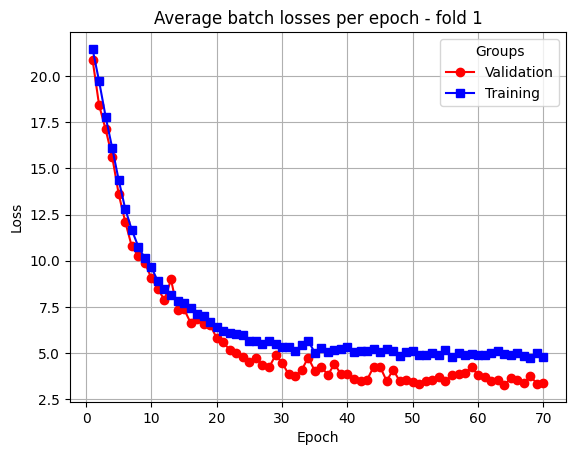

FOLD 2/4
Epoch 001 | Train Loss: 21.3724 | Val Loss: 20.9707 | 
Epoch 002 | Train Loss: 19.7100 | Val Loss: 18.6327 | 
Epoch 003 | Train Loss: 18.0248 | Val Loss: 17.2241 | 
Epoch 004 | Train Loss: 16.1917 | Val Loss: 15.4576 | 
Epoch 005 | Train Loss: 14.4365 | Val Loss: 13.0867 | 
Epoch 006 | Train Loss: 12.9900 | Val Loss: 12.7997 | 
Epoch 007 | Train Loss: 11.7741 | Val Loss: 11.6012 | 
Epoch 008 | Train Loss: 10.8392 | Val Loss: 10.2009 | 
Epoch 009 | Train Loss: 10.1366 | Val Loss: 9.9996 | 
Epoch 010 | Train Loss: 9.4889 | Val Loss: 9.0417 | 
Epoch 011 | Train Loss: 9.0318 | Val Loss: 8.2917 | 
Epoch 012 | Train Loss: 8.5836 | Val Loss: 8.1624 | 
Epoch 013 | Train Loss: 8.1218 | Val Loss: 8.6039 | 
Epoch 014 | Train Loss: 7.6927 | Val Loss: 7.3217 | 
Epoch 015 | Train Loss: 7.4812 | Val Loss: 6.8703 | 
Epoch 016 | Train Loss: 7.2096 | Val Loss: 6.5240 | 
Epoch 017 | Train Loss: 6.9465 | Val Loss: 6.3649 | 
Epoch 018 | Train Loss: 6.6861 | Val Loss: 6.5253 | 
Epoch 019 | Train Lo

KeyboardInterrupt: 

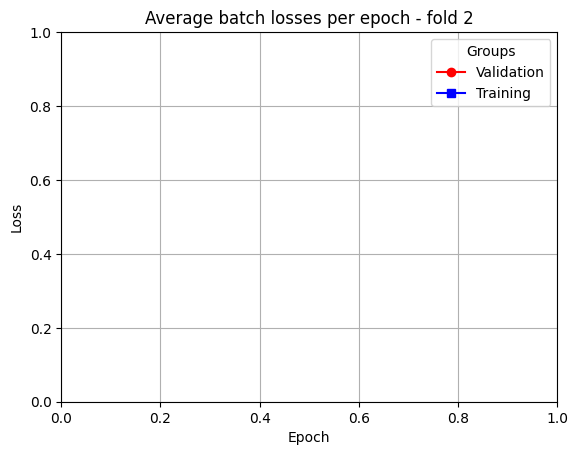

In [5]:
my_NNRegressor = NNRegressor(
    model_class=ConvNN,
    model_parameters={'end_dim': 51},
    loss_fnc=RMSELoss(),
    batch_size = 50,
    learning_rate = 0.001,
    max_epochs = 70,
    patience = 50
)

results = cross_validate_NN(
    my_NNRegressor,
    X_guided_windows_train_val_folds,
    Y_guided_labels_train_val_folds,
    metric_fns={'RMSE': RMSE, 'NMSE': NMSE},
    verbose=3)

#### Benchmark: 4-fold Leave-One-Session-Out cross-validation of CNN model on *freemoves* dataset - 

FOLD 1/4
Epoch 001 | Train Loss: 26.6392 | Val Loss: 23.4869 | 
Epoch 002 | Train Loss: 24.8450 | Val Loss: 22.2742 | 
Epoch 003 | Train Loss: 22.5841 | Val Loss: 20.5610 | 
Epoch 004 | Train Loss: 20.0499 | Val Loss: 19.3460 | 
Epoch 005 | Train Loss: 17.4321 | Val Loss: 16.0427 | 
Epoch 006 | Train Loss: 15.0036 | Val Loss: 15.5941 | 
Epoch 007 | Train Loss: 13.0047 | Val Loss: 12.7486 | 
Epoch 008 | Train Loss: 11.7035 | Val Loss: 11.2604 | 
Epoch 009 | Train Loss: 10.9532 | Val Loss: 11.4518 | 
Epoch 010 | Train Loss: 10.4271 | Val Loss: 11.0626 | 
Epoch 011 | Train Loss: 10.1727 | Val Loss: 10.8125 | 
Epoch 012 | Train Loss: 9.9928 | Val Loss: 10.8782 | 
Epoch 013 | Train Loss: 9.7289 | Val Loss: 10.4932 | 
Epoch 014 | Train Loss: 9.6589 | Val Loss: 10.5856 | 
Epoch 015 | Train Loss: 9.5018 | Val Loss: 11.1535 | 
Epoch 016 | Train Loss: 9.5989 | Val Loss: 11.0505 | 
Epoch 017 | Train Loss: 9.3764 | Val Loss: 11.1648 | 
Epoch 018 | Train Loss: 9.3677 | Val Loss: 11.2042 | 
Epoch 01

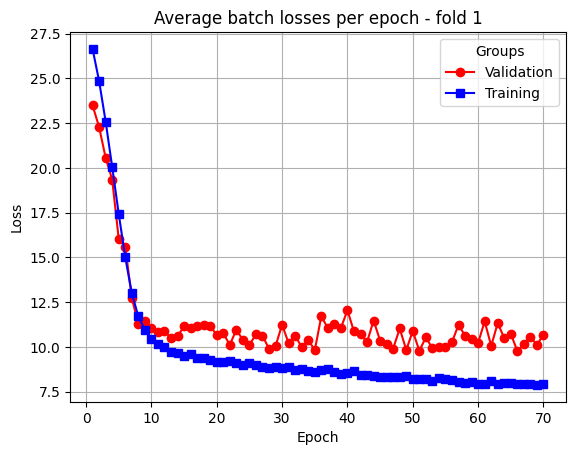

FOLD 2/4
Epoch 001 | Train Loss: 24.2285 | Val Loss: 29.1877 | 
Epoch 002 | Train Loss: 22.4710 | Val Loss: 26.2741 | 
Epoch 003 | Train Loss: 20.2363 | Val Loss: 25.2094 | 
Epoch 004 | Train Loss: 17.7782 | Val Loss: 20.6320 | 
Epoch 005 | Train Loss: 15.3941 | Val Loss: 19.6816 | 
Epoch 006 | Train Loss: 13.3453 | Val Loss: 17.2878 | 
Epoch 007 | Train Loss: 11.7170 | Val Loss: 17.1519 | 
Epoch 008 | Train Loss: 10.6733 | Val Loss: 14.2138 | 
Epoch 009 | Train Loss: 10.0590 | Val Loss: 13.5858 | 
Epoch 010 | Train Loss: 9.6792 | Val Loss: 15.2777 | 
Epoch 011 | Train Loss: 9.3721 | Val Loss: 14.7236 | 
Epoch 012 | Train Loss: 9.1961 | Val Loss: 14.5627 | 
Epoch 013 | Train Loss: 9.1484 | Val Loss: 13.8311 | 
Epoch 014 | Train Loss: 8.8591 | Val Loss: 13.5491 | 
Epoch 015 | Train Loss: 8.8878 | Val Loss: 14.6827 | 
Epoch 016 | Train Loss: 8.7279 | Val Loss: 14.2355 | 
Epoch 017 | Train Loss: 8.5652 | Val Loss: 14.8390 | 
Epoch 018 | Train Loss: 8.5634 | Val Loss: 13.9398 | 
Epoch 019 

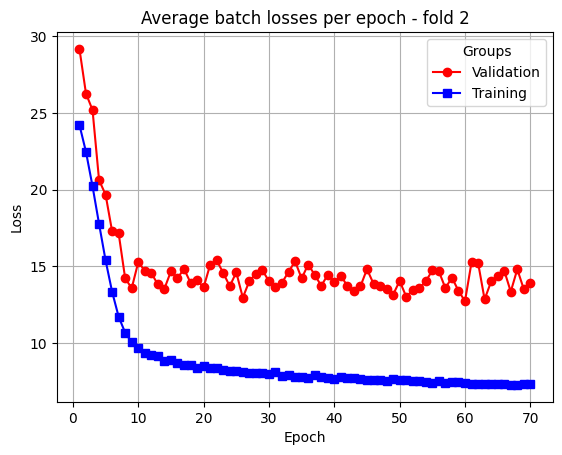

FOLD 3/4
Epoch 001 | Train Loss: 26.1810 | Val Loss: 24.4115 | 
Epoch 002 | Train Loss: 24.3278 | Val Loss: 23.6130 | 
Epoch 003 | Train Loss: 22.0428 | Val Loss: 20.6333 | 
Epoch 004 | Train Loss: 19.5502 | Val Loss: 17.6299 | 
Epoch 005 | Train Loss: 17.0486 | Val Loss: 15.4490 | 
Epoch 006 | Train Loss: 14.5956 | Val Loss: 12.8811 | 
Epoch 007 | Train Loss: 12.8686 | Val Loss: 14.0669 | 
Epoch 008 | Train Loss: 11.4571 | Val Loss: 11.6041 | 
Epoch 009 | Train Loss: 10.6066 | Val Loss: 11.1577 | 
Epoch 010 | Train Loss: 10.1916 | Val Loss: 11.3825 | 
Epoch 011 | Train Loss: 9.9153 | Val Loss: 10.7749 | 
Epoch 012 | Train Loss: 9.8188 | Val Loss: 10.8480 | 
Epoch 013 | Train Loss: 9.4450 | Val Loss: 10.7958 | 
Epoch 014 | Train Loss: 9.5533 | Val Loss: 10.7314 | 
Epoch 015 | Train Loss: 9.4384 | Val Loss: 10.9394 | 
Epoch 016 | Train Loss: 9.2469 | Val Loss: 12.2232 | 
Epoch 017 | Train Loss: 9.2080 | Val Loss: 11.7389 | 
Epoch 018 | Train Loss: 9.2529 | Val Loss: 10.8666 | 
Epoch 019

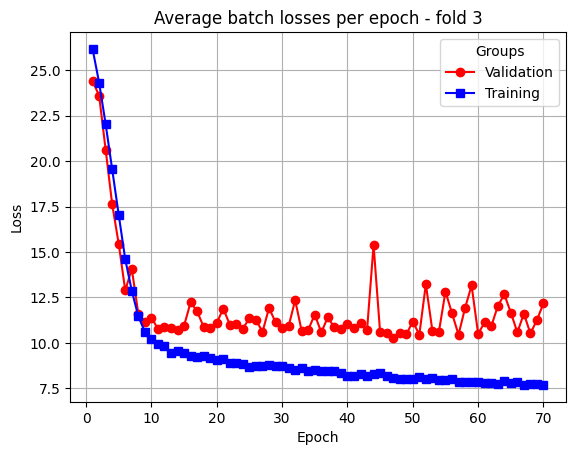

FOLD 4/4
Epoch 001 | Train Loss: 26.9891 | Val Loss: 21.7894 | 
Epoch 002 | Train Loss: 25.2119 | Val Loss: 20.2294 | 
Epoch 003 | Train Loss: 22.9677 | Val Loss: 19.6933 | 
Epoch 004 | Train Loss: 20.4467 | Val Loss: 17.3505 | 
Epoch 005 | Train Loss: 17.8250 | Val Loss: 13.6982 | 
Epoch 006 | Train Loss: 15.3476 | Val Loss: 14.2173 | 
Epoch 007 | Train Loss: 13.2757 | Val Loss: 12.0222 | 
Epoch 008 | Train Loss: 12.0068 | Val Loss: 10.4222 | 
Epoch 009 | Train Loss: 11.1900 | Val Loss: 10.2779 | 
Epoch 010 | Train Loss: 10.8765 | Val Loss: 9.9421 | 
Epoch 011 | Train Loss: 10.4438 | Val Loss: 10.2378 | 
Epoch 012 | Train Loss: 10.2049 | Val Loss: 9.4042 | 
Epoch 013 | Train Loss: 10.1400 | Val Loss: 9.2572 | 
Epoch 014 | Train Loss: 10.0193 | Val Loss: 9.3804 | 
Epoch 015 | Train Loss: 9.8674 | Val Loss: 9.1811 | 
Epoch 016 | Train Loss: 9.8257 | Val Loss: 9.2253 | 
Epoch 017 | Train Loss: 9.5897 | Val Loss: 9.2210 | 
Epoch 018 | Train Loss: 9.7187 | Val Loss: 9.0814 | 
Epoch 019 | T

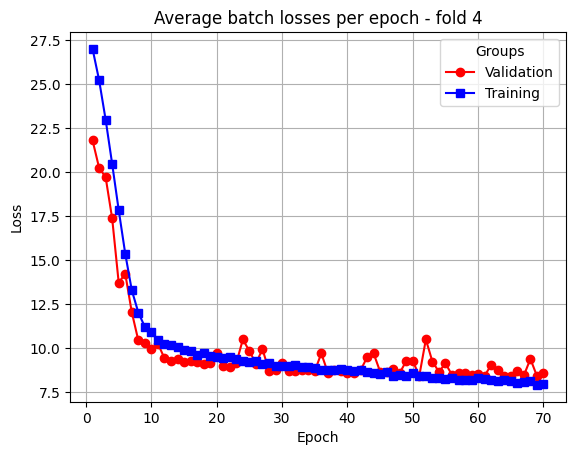


Average Scores across folds:
RMSE: train=7.4778, val=12.4031
NMSE: train=0.3393, val=1.0418


In [13]:
my_NNRegressor = NNRegressor(
    model_class=ConvNN,
    model_parameters={'end_dim': 51},
    loss_fnc=RMSELoss(),
    batch_size = 50,
    learning_rate = 0.001,
    max_epochs = 70,
    patience = 50
)

results = cross_validate_NN(
    my_NNRegressor,
    X_freemoves_windows_train_val_folds,
    Y_freemoves_labels_train_val_folds,
    metric_fns={'RMSE': RMSE, 'NMSE': NMSE},
    verbose=3)

#### 4-fold Leave-One-Session-Out cross-validation of DANN model on *guided* dataset

FOLD 1/4


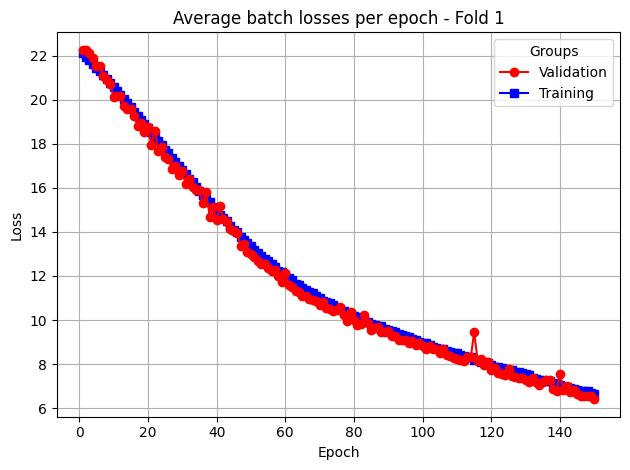

FOLD 2/4


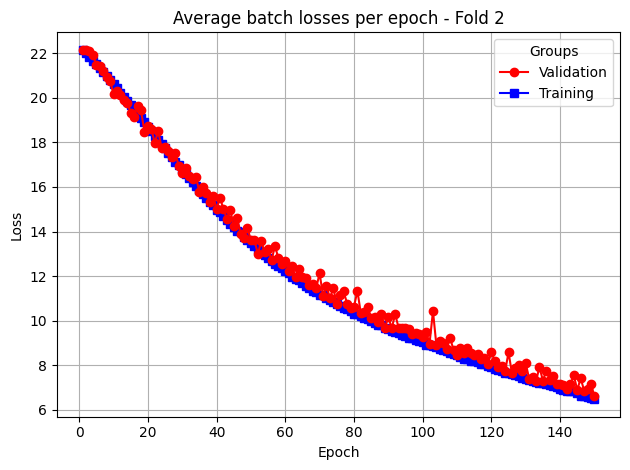

FOLD 3/4


KeyboardInterrupt: 

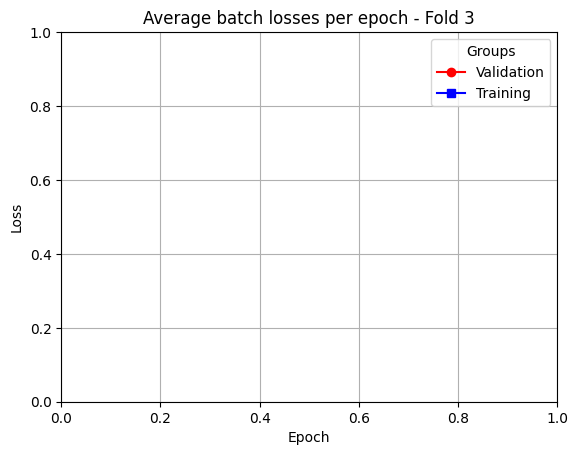

In [13]:
results = cross_validate_dann(
    model_builder=lambda: DANNModel(lambda_grl=0.3, num_domains=4, output_dim=51),
    X_folds=X_guided_windows_train_val_folds,
    Y_folds=Y_guided_labels_train_val_folds,
    tensor_dataset=DANNWindowTensor,
    metric_fns={"RMSE": RMSE, "NMSE": NMSE},
    max_epochs=150,
    verbose=3,
)

#### 4-fold Leave-One-Session-Out cross-validation of DANN model on *freemoves* dataset

In [5]:

results = cross_validate_dann(
    model_builder=lambda: DANNModel(lambda_grl=0.3, num_domains=5, output_dim=51),
    X_folds=X_freemoves_windows,
    Y_folds=Y_freemoves_labels,
    tensor_dataset=DANNWindowTensor,
    metric_fns={"RMSE": RMSE, "NMSE": NMSE},
    max_epochs=150,
    patience=100,
    verbose=2,
    batch_size=64
)

Epoch 01 | Train RMSE: 26.7744 | Train NMSE: 4.0789 | Val RMSE: 24.1718 | Dom Train Acc: 55.73%
           λ = 0.100
Epoch 02 | Train RMSE: 25.3974 | Train NMSE: 3.6701 | Val RMSE: 22.5728 | Dom Train Acc: 57.40%
           λ = 0.200
Epoch 03 | Train RMSE: 23.7536 | Train NMSE: 3.2104 | Val RMSE: 22.2159 | Dom Train Acc: 59.07%
           λ = 0.300
Epoch 04 | Train RMSE: 22.0129 | Train NMSE: 2.7571 | Val RMSE: 21.7686 | Dom Train Acc: 49.58%
           λ = 0.400
Epoch 05 | Train RMSE: 20.2282 | Train NMSE: 2.3282 | Val RMSE: 20.6922 | Dom Train Acc: 49.06%
           λ = 0.500
Epoch 06 | Train RMSE: 18.4109 | Train NMSE: 1.9286 | Val RMSE: 20.4563 | Dom Train Acc: 48.63%
           λ = 0.600
Epoch 07 | Train RMSE: 16.9363 | Train NMSE: 1.6320 | Val RMSE: 16.4968 | Dom Train Acc: 59.72%
           λ = 0.700
Epoch 08 | Train RMSE: 15.3197 | Train NMSE: 1.3354 | Val RMSE: 14.0493 | Dom Train Acc: 56.69%
           λ = 0.800
Epoch 09 | Train RMSE: 14.0676 | Train NMSE: 1.1260 | Val RMSE: 

#### 4-fold Leave-One-Session-Out cross-validation of TemporalDANN model on *guided* dataset

In [7]:
from config.transformers import DeltaFeatureTransformer

In [8]:
diff_transform = DeltaFeatureTransformer()

# USING THE SPLIT DATA BUT MAYBE WE GOTTA DO IT BEFORE (losing 2 not 1 (?))

X_freemoves_diff_train = diff_transform.transform(X_freemoves_windows_train_val_folds, combination=2)
X_guided_diff_train = diff_transform.transform(X_guided_windows_train_val_folds, combination=2)

FOLD 1/4


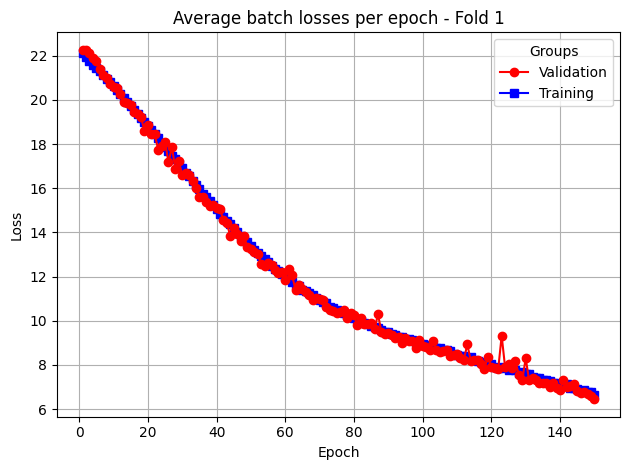

FOLD 2/4


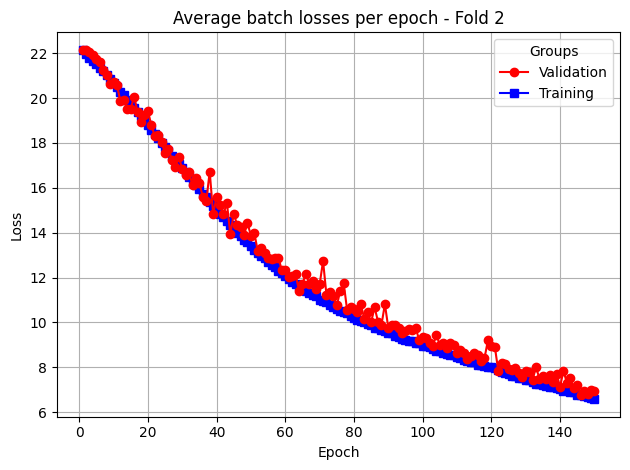

FOLD 3/4


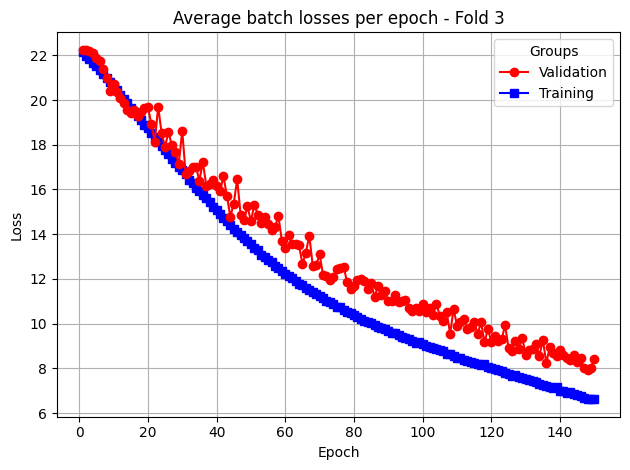

FOLD 4/4


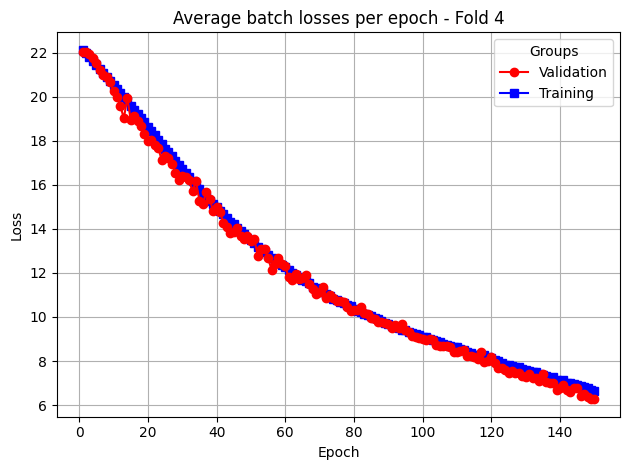


Average Scores across folds:
RMSE: train=18.6509, val=7.0262
NMSE: train=1.7318, val=0.2483


In [10]:
results = cross_validate_dann(
    model_builder=lambda: TemporalDANNModel(lambda_grl=0.3, num_domains=4, output_dim=51, in_channels=16),
    X_folds=X_guided_diff_train,
    Y_folds=Y_guided_labels_train_val_folds,
    tensor_dataset=DANNWindowTensor,
    metric_fns={"RMSE": RMSE, "NMSE": NMSE},
    max_epochs=150,
    patience=20,
    verbose=3,
)

#### 4-fold Leave-One-Session-Out cross-validation of TemporalDANN model on *freemoves* dataset

FOLD 1/4
Early stopping triggered.


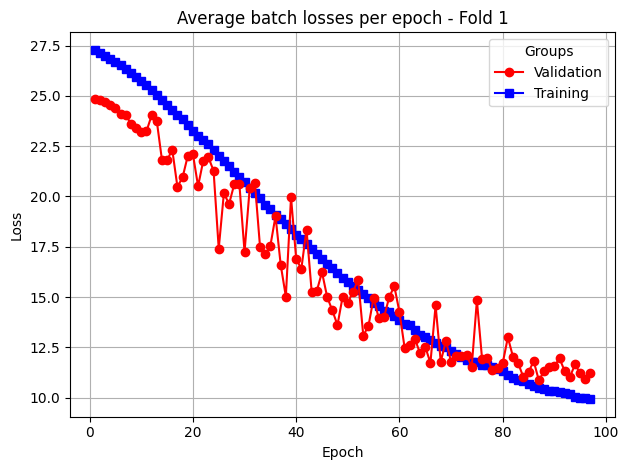

FOLD 2/4
Early stopping triggered.


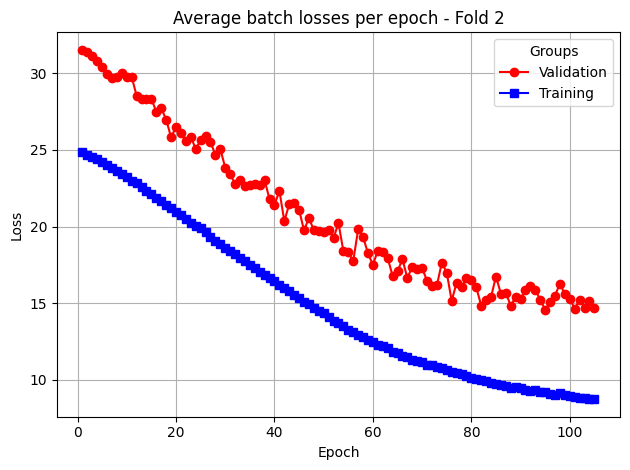

FOLD 3/4
Early stopping triggered.


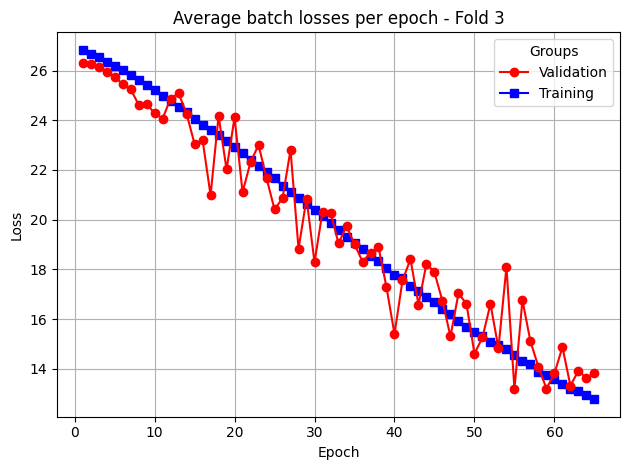

FOLD 4/4


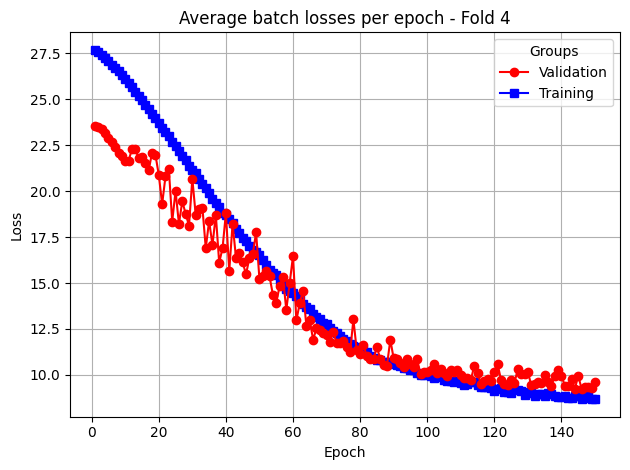


Average Scores across folds:
RMSE: train=17.0931, val=12.3264
NMSE: train=1.7758, val=1.0020


In [12]:

results = cross_validate_dann(
    model_builder=lambda: TemporalDANNModel(lambda_grl=0.3, num_domains=4, output_dim=51, in_channels=16),
    X_folds=X_freemoves_diff_train,
    Y_folds=Y_freemoves_labels_train_val_folds,
    tensor_dataset=DANNWindowTensor,
    metric_fns={"RMSE": RMSE, "NMSE": NMSE},
    max_epochs=150,
    verbose=3,
)

#  Ensemble

Design and implement two ensembling strategies that combine the predictions of all individual regression models you implemented, each independently trained on distinct feature representations of the EMG signals. The two required ensembling approaches are the following:
- Compute the average of the predicted values
- Use a meta-learner strategy (often referred to as stacking), in which a separate model—trained on the outputs of the base learners—generates the ensemble prediction
For each ensemble strategy, compare and document the ensemble’s regression performance against each of its constituent base models using consistent regression metrics. Additionally, for the metalearner strategy, determine and discuss the relative contribution of each base model to the final ensemble prediction. Discuss how the bias-variance tradeoff relates to the observed (or expected) evolution of performance.

## Ensemble Method: Voting Regressor

To enhance the robustness and accuracy of our predictions, we employ an ensemble learning technique using a Voting Regressor. The idea behind ensembling is simple: different models may capture different aspects of the signal, and by aggregating their predictions, we can reduce variance, mitigate individual model weaknesses, and improve overall robustness and accuracy.

We implement a **Voting Regressor**, which performs prediction by taking a **weighted average** of the outputs of multiple base regressors. If we denote the predictions of $M$ models as $\hat{y}_1, \hat{y}_2, \ldots, \hat{y}_M$, then the final ensemble prediction is computed as:

$$
\hat{y}_{\text{ensemble}} = \frac{1}{M} \sum_{m=1}^{M} \hat{y}_m
$$]

Our implementation of the Voting Regressor is as a custom scikit-learn-compatible class `VotingRegressor`, which fits each constituent baseline pipeline individually and then combines their predictions at inference time. The ensemble combines both time-domain and Riemannian geometry-based pipelines. Each included model brings a different inductive bias or mathematical structure to the task:

* `baseline_kr`: Kernel Ridge Regression applied to time-domain features.
* `baseline_rf`: Random Forest Regression applied to time-domain features.
* `riem3`, `riem4`: Riemannian geometry-based pipelines utilizing tangent space projections of covariance matrices.

These pipelines were chosen based on their individual performance and the diversity of their approaches to ensure a well-rounded ensemble.

The final ensemble is instantiated as:
```python
voting_estimator = VotingRegressor(
    estimators = [
        baseline_guided_kr,
        baseline_guided_rf,
        riem3,
        riem4
    ]
)
```

In [ ]:
from config.regressors import VotingRegressor

# TO CHECK: ENSEMBLE VOTING CODE

voting_estimator = VotingRegressor(
    estimators = [
        baseline_kr,
        baseline_knn,
        baseline_rf,
        riem_kr,
        riem_knn,
        riem_rf
    ]
)

#### 4-fold Leave-One-Session-Out cross-validation of Voting Regressor model on *guided* dataset

In [ ]:
print('---------------------------------------------------------------------------')
print('Cross-Validation of the pipeline "voting_estimator" on the guided dataset:')
results_guided_voting = cross_validate_pipeline(
    pipeline = voting_estimator,
    X_folds = X_guided_windows_train_val_folds,
    Y_folds = Y_guided_labels_train_val_folds,
    metric_fns = {'RMSE': RMSE, 'NMSE': NMSE},
    n_folds = 4,
    # verbose 0: silent mode; verbose 1: only average across folds values printed; verbose 2: results of all folds printed
    verbose = 1
)

#### 4-fold Leave-One-Session-Out cross-validation of Voting Regressor model on *freemoves* dataset

In [ ]:
print('---------------------------------------------------------------------------')
print('Cross-Validation of the pipeline "voting_estimator" on the freemoves dataset:')
results_freemoves_voting = cross_validate_pipeline(
    pipeline = voting_estimator,
    X_folds = X_freemoves_windows_train_val_folds,
    Y_folds = Y_freemoves_labels_train_val_folds,
    metric_fns = {'RMSE': RMSE, 'NMSE': NMSE},
    n_folds = 4,
    # verbose 0: silent mode; verbose 1: only average across folds values printed; verbose 2: results of all folds printed
    verbose = 1
)

## Ensemble Method: Stackig Regressor

TO DO: ENSEMBLE STACKING DESCRIPTION

In [ ]:
from config.regressors import StackingRegressor

stacking_estimator = StackingRegressor(
    estimators = [
        baseline_kr,
        baseline_knn,
        baseline_rf,
        riem_kr,
        riem_knn,
        riem_rf
    ],
    end_estimator = RandomForestRegressor(
        n_estimators = 50,
        max_depth = 10)
)

#### 4-fold Leave-One-Session-Out cross-validation of Stacking Regressor model on *guided* dataset

In [ ]:
print('---------------------------------------------------------------------------')
print('Cross-Validation of the pipeline "stacking_estimator" on the guided dataset:')
results_guided_voting = cross_validate_pipeline(
    pipeline = stacking_estimator,
    X_folds = X_guided_windows_train_val_folds,
    Y_folds = Y_guided_labels_train_val_folds,
    metric_fns = {'RMSE': RMSE, 'NMSE': NMSE},
    n_folds = 4,
    # verbose 0: silent mode; verbose 1: only average across folds values printed; verbose 2: results of all folds printed
    verbose = 1
)

#### 4-fold Leave-One-Session-Out cross-validation of Stacking Regressor model on *freemoves* dataset

In [ ]:
print('---------------------------------------------------------------------------')
print('Cross-Validation of the pipeline "stacking_estimator" on the freemoves dataset:')
results_freemoves_voting = cross_validate_pipeline(
    pipeline = stacking_estimator,
    X_folds = X_freemoves_windows_train_val_folds,
    Y_folds = Y_freemoves_labels_train_val_folds,
    metric_fns = {'RMSE': RMSE, 'NMSE': NMSE},
    n_folds = 4,
    # verbose 0: silent mode; verbose 1: only average across folds values printed; verbose 2: results of all folds printed
    verbose = 1
)

#  Extra

## Filter

To ensure the quality of the EMG signals and remove unwanted noise, we apply a series of digital signal processing filters to the time window datasets. The filtering process is crucial for obtaining clean and reliable EMG data. 

### Filtering Steps

The `EmgFilterTransformer` class implements the following filtering steps:

1.  **Resampling:** The EMG signals are initially resampled from their original sampling frequency (`original_fs` = 1024 Hz) to a higher target sampling frequency (`target_fs` = 2048 Hz).
Upsampling is performed to minimize high-frequency components not adequately filtered before subsequent filtering stages, particularly for downsampling or bandpass filtering. By increasing the sampling rate, we shift the high-frequency components upwards, providing a larger guard band. This allows the bandpass filter to more effectively attenuate high-frequency noise without it being incorrectly represented as lower frequencies in the processed signal.

2.  **Notch Filter:** A notch filter is applied with a central frequency (`f0`) of 50Hz and a bandwidth (`bw`) of 5Hz to eliminate power line interference to remove power line interference. Power line interference at 50 Hz is a common artifact in EMG recordings, often introduced by electromagnetic coupling from nearby electrical equipment. This narrowband noise can significantly contaminate the EMG signal within its relevant frequency range.

3.  **Bandpass Filter:** A bandpass filter is used to isolate the relevant frequency components of the EMG signal.
The power spectral density of surface EMG signals associated with muscle contractions typically lies within the range of approximately 30-500 Hz (`low` = 30.0 Hz, `high` = 500.0 Hz). Bandpass filtering helps to improve the signal-to-noise ratio by attenuating these out-of-band components. According to Simar et al. (2024), a bandpass filter with a lower cutoff around 30 Hz is suitable for removing movement artifacts in EMG during hand activities.

4.  **Resampling (back to original):** If the signal was initially upsampled, it is downsampled back to the original sampling rate. After the filtering stages, the high-frequency noise components beyond the bandpass range have been attenuated. Therefore, the signal can be represented adequately at the original sampling rate.

### Parameter Choices

The filter parameters were chosen based on established recommendations in the literature for EMG processing during functional tasks [cite: Gramfort et al., 2013; Larson et al., 2023, Simar et al, 2024]:

* `original_fs`: 1024 Hz - The original sampling frequency of the recording.
* `target_fs`: 2048 Hz - The target sampling frequency, chosen to be an integer multiple of the original sampling rate for efficient downsampling and to provide sufficient headroom for filtering.
* `f0`: 50.0 Hz - The center frequency of the notch filter, corresponding to the power line frequency in Belgium (where the data was likely recorded based on common European standards).
* `bw`: 5.0 Hz - The bandwidth of the notch filter, narrow enough to attenuate the power line interference effectively without significantly affecting the adjacent frequency components of the EMG signal.
* `low`: 10.0 Hz - The lower cutoff frequency of the bandpass filter. This lower value, compared to the more typical 30 Hz, is chosen to potentially retain more low-frequency information in the EMG signal, which might be relevant for distinguishing between different hand poses, especially those involving sustained muscle activity or subtle changes in force like in the *free gestures dataset*.
* `high`: 500.0 Hz - The higher cutoff frequency of the bandpass filter, chosen to remove high-frequency noise while preserving the essential spectral content of the EMG signal related to muscle fiber action potentials. This range is commonly used in EMG analysis for capturing relevant neuromuscular information.
* `order`: 4 - The order of the Butterworth filter, providing a roll-off rate of 24 dB per octave. This order offers a good compromise between effective attenuation of out-of-band frequencies and minimizing phase distortion within the passband.

To further illustrate the effect of the filtering process, we included the following plots:

1.  **Raw EMG signal for 1 channel - 4 seconds - guided dataset:** Show a segment of the raw EMG signal for *guided gestures dataset* to visualize the noise and artifacts present.
2.  **Filter EMG signal for 1 channel - 4 seconds - guided dataset:** Show the same segment of the EMG signal for *guided gestures dataset* after applying the `EmgFilterTransformer`, demonstrating the reduction in noise and artifacts.
1.  **Raw EMG signal for 1 channel - 4 seconds - freemoves dataset:** Show a segment of the raw EMG signal for *free gestures dataset* to visualize the noise and artifacts present.
2.  **Filter EMG signal for 1 channel - 4 seconds - freemoves dataset:** Show the same segment of the EMG signal for *free gestures dataset* after applying the `EmgFilterTransformer`, demonstrating the reduction in noise and artifacts.

In [ ]:
from config.utils import plot_emg_channels
from config.transformers import EmgFilterTransformer

# Apply filter
X_guided_filter = EmgFilterTransformer().fit_transform(X_guided)
X_freemoves_filter = EmgFilterTransformer().fit_transform(X_freemoves)

# Plots guided
plot_emg_channels(
    X_guided, 
    fs=1024, 
    duration_sec=4,
    title="Raw EMG signal for 1 channel - 4 seconds - guided dataset:", 
    channels_to_plot=[0]
    )
plot_emg_channels(
    X_guided_filter, 
    fs=1024, 
    duration_sec=4,
    title="Filtered EMG signal for 1 channel - 4 seconds - guided dataset:", 
    channels_to_plot=[0]
    )

# Plots freemoves
plot_emg_channels(
    X_freemoves, 
    fs=1024, 
    duration_sec=4,
    title="Raw EMG signal for 1 channel - 4 seconds - freemoves dataset:", 
    channels_to_plot=[0]
    )

plot_emg_channels(
    X_freemoves_filter, 
    fs=1024, 
    duration_sec=4,
    title="Filtered EMG signal for 1 channel - 4 seconds - freemoves dataset:", 
    channels_to_plot=[0]
    )

## Cross validation full data

## Fancy 3D plots

## Autoencoder

# Final models